<a href="https://colab.research.google.com/github/AxelRK200/trend_finder_dataiku/blob/main/Exploration/PPS_Vs_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ppscore

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from copy import copy
from scipy import stats
import math
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import ppscore as pps
from datetime import datetime

# Import et conversion

#### Dataframe index de référence 

In [3]:
df_index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/FRED_daily/NASDAQ100.csv")
df_index.rename(columns={"NASDAQ100": "Close", "DATE":"Date"}, inplace=True)

In [4]:
df_index["Date"] = pd.to_datetime(df_index["Date"])

In [5]:
df_index.sort_values(by="Date", ascending=True, inplace=True)
df_index.reset_index(drop=True, inplace=True)

In [6]:
df_index.dtypes

Date     datetime64[ns]
Close            object
dtype: object

In [7]:
df_index.isnull().sum()

Date     0
Close    0
dtype: int64

In [8]:
df_index.head(1)

Date   Close
0 1986-01-02  131.25

#### Datatframes indicateurs

In [9]:
path="/content/drive/MyDrive/Colab Notebooks/sources/FRED_daily/"
sources_list = ["AAA10Y.csv","BAMLH0A0HYM2EY.csv","BAMLC0A0CMEY.csv","BAMLC0A0CM_spread.csv","BAMLH0A0HYM2.csv","BAMLH0A3HYCEY.csv","CBBTCUSD.csv",\
                "CBETHUSD.csv","DAAA.csv","DEXUSEU.csv","GVZCLS.csv","RVXCLS.csv","T10Y2Y-2.csv","T10YFF.csv","VIXCLS.csv","VXDCLS.csv","VXNCLS.csv","WILL5000PR.csv"]

In [10]:
def clean_incorrect_values(df):
  ''' identifie les lignes contenant "." au lieu d'une valeur
  et attribue Nan à la place. Cela permettra ensuite une interpolation'''

  col_list = df.columns.to_list()

  # remplace les valeurs "." par NaN
  indexes_to_replace = df[df[col_list[1]]=="."].index.to_list() 
  df.loc[indexes_to_replace,col_list[1]] = math.nan

  # convertions d'objet vers float, possible avec NaN 
  df[col_list[1]] = df[col_list[1]].astype(float)

  # interpolation linéaire pour combler les valeurs NaN
  df[col_list[1]].interpolate(methode='linear', inplace=True)

  # renommage avant jointure
  df.rename(columns={"DATE": "Date"}, inplace=True)
  
  return df

In [11]:
df_agg = clean_incorrect_values(df_index)

for indicateur in sources_list:
  
  df_temp = pd.read_csv(path+indicateur)

  # Conversion de la date format obj -> datetime
  df_temp["DATE"] = pd.to_datetime(df_temp["DATE"])

  df_temp = clean_incorrect_values(df_temp)

  if df_temp.isnull().sum().all() == 0:
    date_min = df_temp["Date"].min().strftime("%Y-%m-%d")
    print("Conversion ok pour {}. Date Min : {}".format(indicateur, date_min))

    df_agg = df_agg.merge(df_temp, how='left', on='Date')

Conversion ok pour AAA10Y.csv. Date Min : 1983-01-03
Conversion ok pour BAMLH0A0HYM2EY.csv. Date Min : 1996-12-31
Conversion ok pour BAMLC0A0CMEY.csv. Date Min : 1996-12-31
Conversion ok pour BAMLC0A0CM_spread.csv. Date Min : 1996-12-31
Conversion ok pour BAMLH0A0HYM2.csv. Date Min : 1996-12-31
Conversion ok pour BAMLH0A3HYCEY.csv. Date Min : 1996-12-31
Conversion ok pour CBBTCUSD.csv. Date Min : 2014-12-01
Conversion ok pour CBETHUSD.csv. Date Min : 2016-05-18
Conversion ok pour DAAA.csv. Date Min : 1983-01-03
Conversion ok pour DEXUSEU.csv. Date Min : 1999-01-04
Conversion ok pour GVZCLS.csv. Date Min : 2008-06-03
Conversion ok pour RVXCLS.csv. Date Min : 2004-01-02
Conversion ok pour T10Y2Y-2.csv. Date Min : 1985-01-02
Conversion ok pour T10YFF.csv. Date Min : 1985-01-02
Conversion ok pour VIXCLS.csv. Date Min : 1990-01-02
Conversion ok pour VXDCLS.csv. Date Min : 1997-10-07
Conversion ok pour VXNCLS.csv. Date Min : 2001-02-02
Conversion ok pour WILL5000PR.csv. Date Min : 1970-12-31

In [12]:
df_agg.columns

Index(['Date', 'Close', 'AAA10Y', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY',
       'BAMLC0A0CM', 'BAMLH0A0HYM2', 'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD',
       'DAAA', 'DEXUSEU', 'GVZCLS', 'RVXCLS', 'T10Y2Y', 'T10YFF', 'VIXCLS',
       'VXDCLS', 'VXNCLS', 'WILL5000PR'],
      dtype='object')

In [13]:
# On coupe avant que trop de valeurs ne soient perdues au moment de l'étude. Dernières données DL au 24/02
df_agg = df_agg.loc[(df_agg["Date"]>="1997-10-07") & (df_agg["Date"]<="2023-02-23")]
df_agg.reset_index(drop=True, inplace=True)

In [14]:
df_agg.tail()

Date     Close  AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLC0A0CM  \
6618 2023-02-17  12358.18    0.83            8.50          5.40        1.26   
6619 2023-02-20  12209.24    0.82            8.50          5.40        1.26   
6620 2023-02-21  12060.30    0.81            8.73          5.54        1.28   
6621 2023-02-22  12066.27    0.78            8.65          5.52        1.28   
6622 2023-02-23  12180.14    0.80            8.50          5.48        1.28   

      BAMLH0A0HYM2  BAMLH0A3HYCEY  CBBTCUSD  CBETHUSD   DAAA  DEXUSEU  GVZCLS  \
6618          4.38          14.35  24562.04   1693.89  4.650  1.06780  14.690   
6619          4.38          14.36  24835.63   1703.34  4.705  1.06675  15.085   
6620          4.49          14.67  24447.91   1659.19  4.760  1.06570  15.480   
6621          4.41          14.62  24187.63   1643.17  4.710  1.06230  15.050   
6622          4.30          14.40  23938.48   1649.70  4.680  1.05830  14.840   

      RVXCLS  T10Y2Y  T10YFF  VIXCLS  VXDCLS  VXNCLS  WILL5000PR  
6618  23.100   -0.78  -0.760   20.02  17.310  25.820    41628.20  
6619  24.785   -0.75  -0.695   21.23  18.435  27.195    41186.31  
6620  26.470   -0.72  -0.630   22.87  19.560  28.570    40744.42  
6621  26.050   -0.73  -0.650   22.29  19.350  28.020    40715.27  
6622  24.980   -0.78  -0.700   21.14  18.150  26.830    40922.81

In [15]:
df_agg.describe()

Close       AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY   BAMLC0A0CM  \
count   6623.000000  6623.000000     6623.000000   6623.000000  6623.000000   
mean    4092.294575     1.513672        8.477034      4.667217     1.550091   
std     3683.397571     0.424922        2.937843      1.639182     0.844918   
min      804.640000     0.630000        3.920000      1.790000     0.540000   
25%     1602.535000     1.190000        6.300000      3.270000     1.050000   
50%     2378.580000     1.530000        7.850000      4.480000     1.370000   
75%     4820.905000     1.810000       10.050000      6.000000     1.720000   
max    16573.340000     3.200000       23.260000      9.320000     6.560000   

       BAMLH0A0HYM2  BAMLH0A3HYCEY      CBBTCUSD     CBETHUSD         DAAA  \
count   6623.000000    6623.000000   2149.000000  1767.000000  6623.000000   
mean       5.490172      14.225901  13315.583025   914.339994     4.931301   
std        2.588756       5.615849  16160.290160  1125.419728     1.390509   
min        2.410000       6.520000    120.000000     6.750000     2.010000   
25%        3.750000      10.497500    798.990000   165.970000     3.870000   
50%        4.800000      12.150000   7439.290000   325.410000     5.040000   
75%        6.475000      16.385000  18550.010000  1383.390000     5.820000   
max       21.820000      45.020000  67510.060000  4805.950000     8.120000   

           DEXUSEU       GVZCLS       RVXCLS       T10Y2Y       T10YFF  \
count  6299.000000  3843.000000  4995.000000  6623.000000  6623.000000   
mean      1.192251    18.908215    24.714964     1.110453     1.439986   
std       0.158690     7.164486     9.674790     0.929765     1.227923   
min       0.827000     8.880000    11.830000    -0.840000    -1.750000   
25%       1.091350    14.835000    18.130000     0.230000     0.475000   
50%       1.186700    17.480000    22.040000     1.110000     1.470000   
75%       1.310950    21.240000    28.550000     1.900000     2.410000   
max       1.601000    64.530000    87.620000     2.910000     3.870000   

            VIXCLS       VXDCLS       VXNCLS    WILL5000PR  
count  6623.000000  6623.000000  5755.000000   6623.000000  
mean     20.622659    19.555350    25.082015  18443.498234  
std       8.527768     7.897748    11.542455  10043.428875  
min       9.140000     2.710000    10.310000   6800.080000  
25%      14.330000    13.790000    16.850000  11356.155000  
50%      19.090000    17.950000    21.320000  13842.140000  
75%      24.415000    23.140000    29.185000  22461.550000  
max      82.690000    74.600000    80.640000  49174.620000

# EDA

## On raw data

array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'AAA10Y'}>,
        <AxesSubplot:title={'center':'BAMLH0A0HYM2EY'}>,
        <AxesSubplot:title={'center':'BAMLC0A0CMEY'}>],
       [<AxesSubplot:title={'center':'BAMLC0A0CM'}>,
        <AxesSubplot:title={'center':'BAMLH0A0HYM2'}>,
        <AxesSubplot:title={'center':'BAMLH0A3HYCEY'}>,
        <AxesSubplot:title={'center':'CBBTCUSD'}>],
       [<AxesSubplot:title={'center':'CBETHUSD'}>,
        <AxesSubplot:title={'center':'DAAA'}>,
        <AxesSubplot:title={'center':'DEXUSEU'}>,
        <AxesSubplot:title={'center':'GVZCLS'}>],
       [<AxesSubplot:title={'center':'RVXCLS'}>,
        <AxesSubplot:title={'center':'T10Y2Y'}>,
        <AxesSubplot:title={'center':'T10YFF'}>,
        <AxesSubplot:title={'center':'VIXCLS'}>],
       [<AxesSubplot:title={'center':'VXDCLS'}>,
        <AxesSubplot:title={'center':'VXNCLS'}>,
        <AxesSubplot:title={'center':'WILL5000PR'}>, <AxesSubplot:>]],
      dtyp

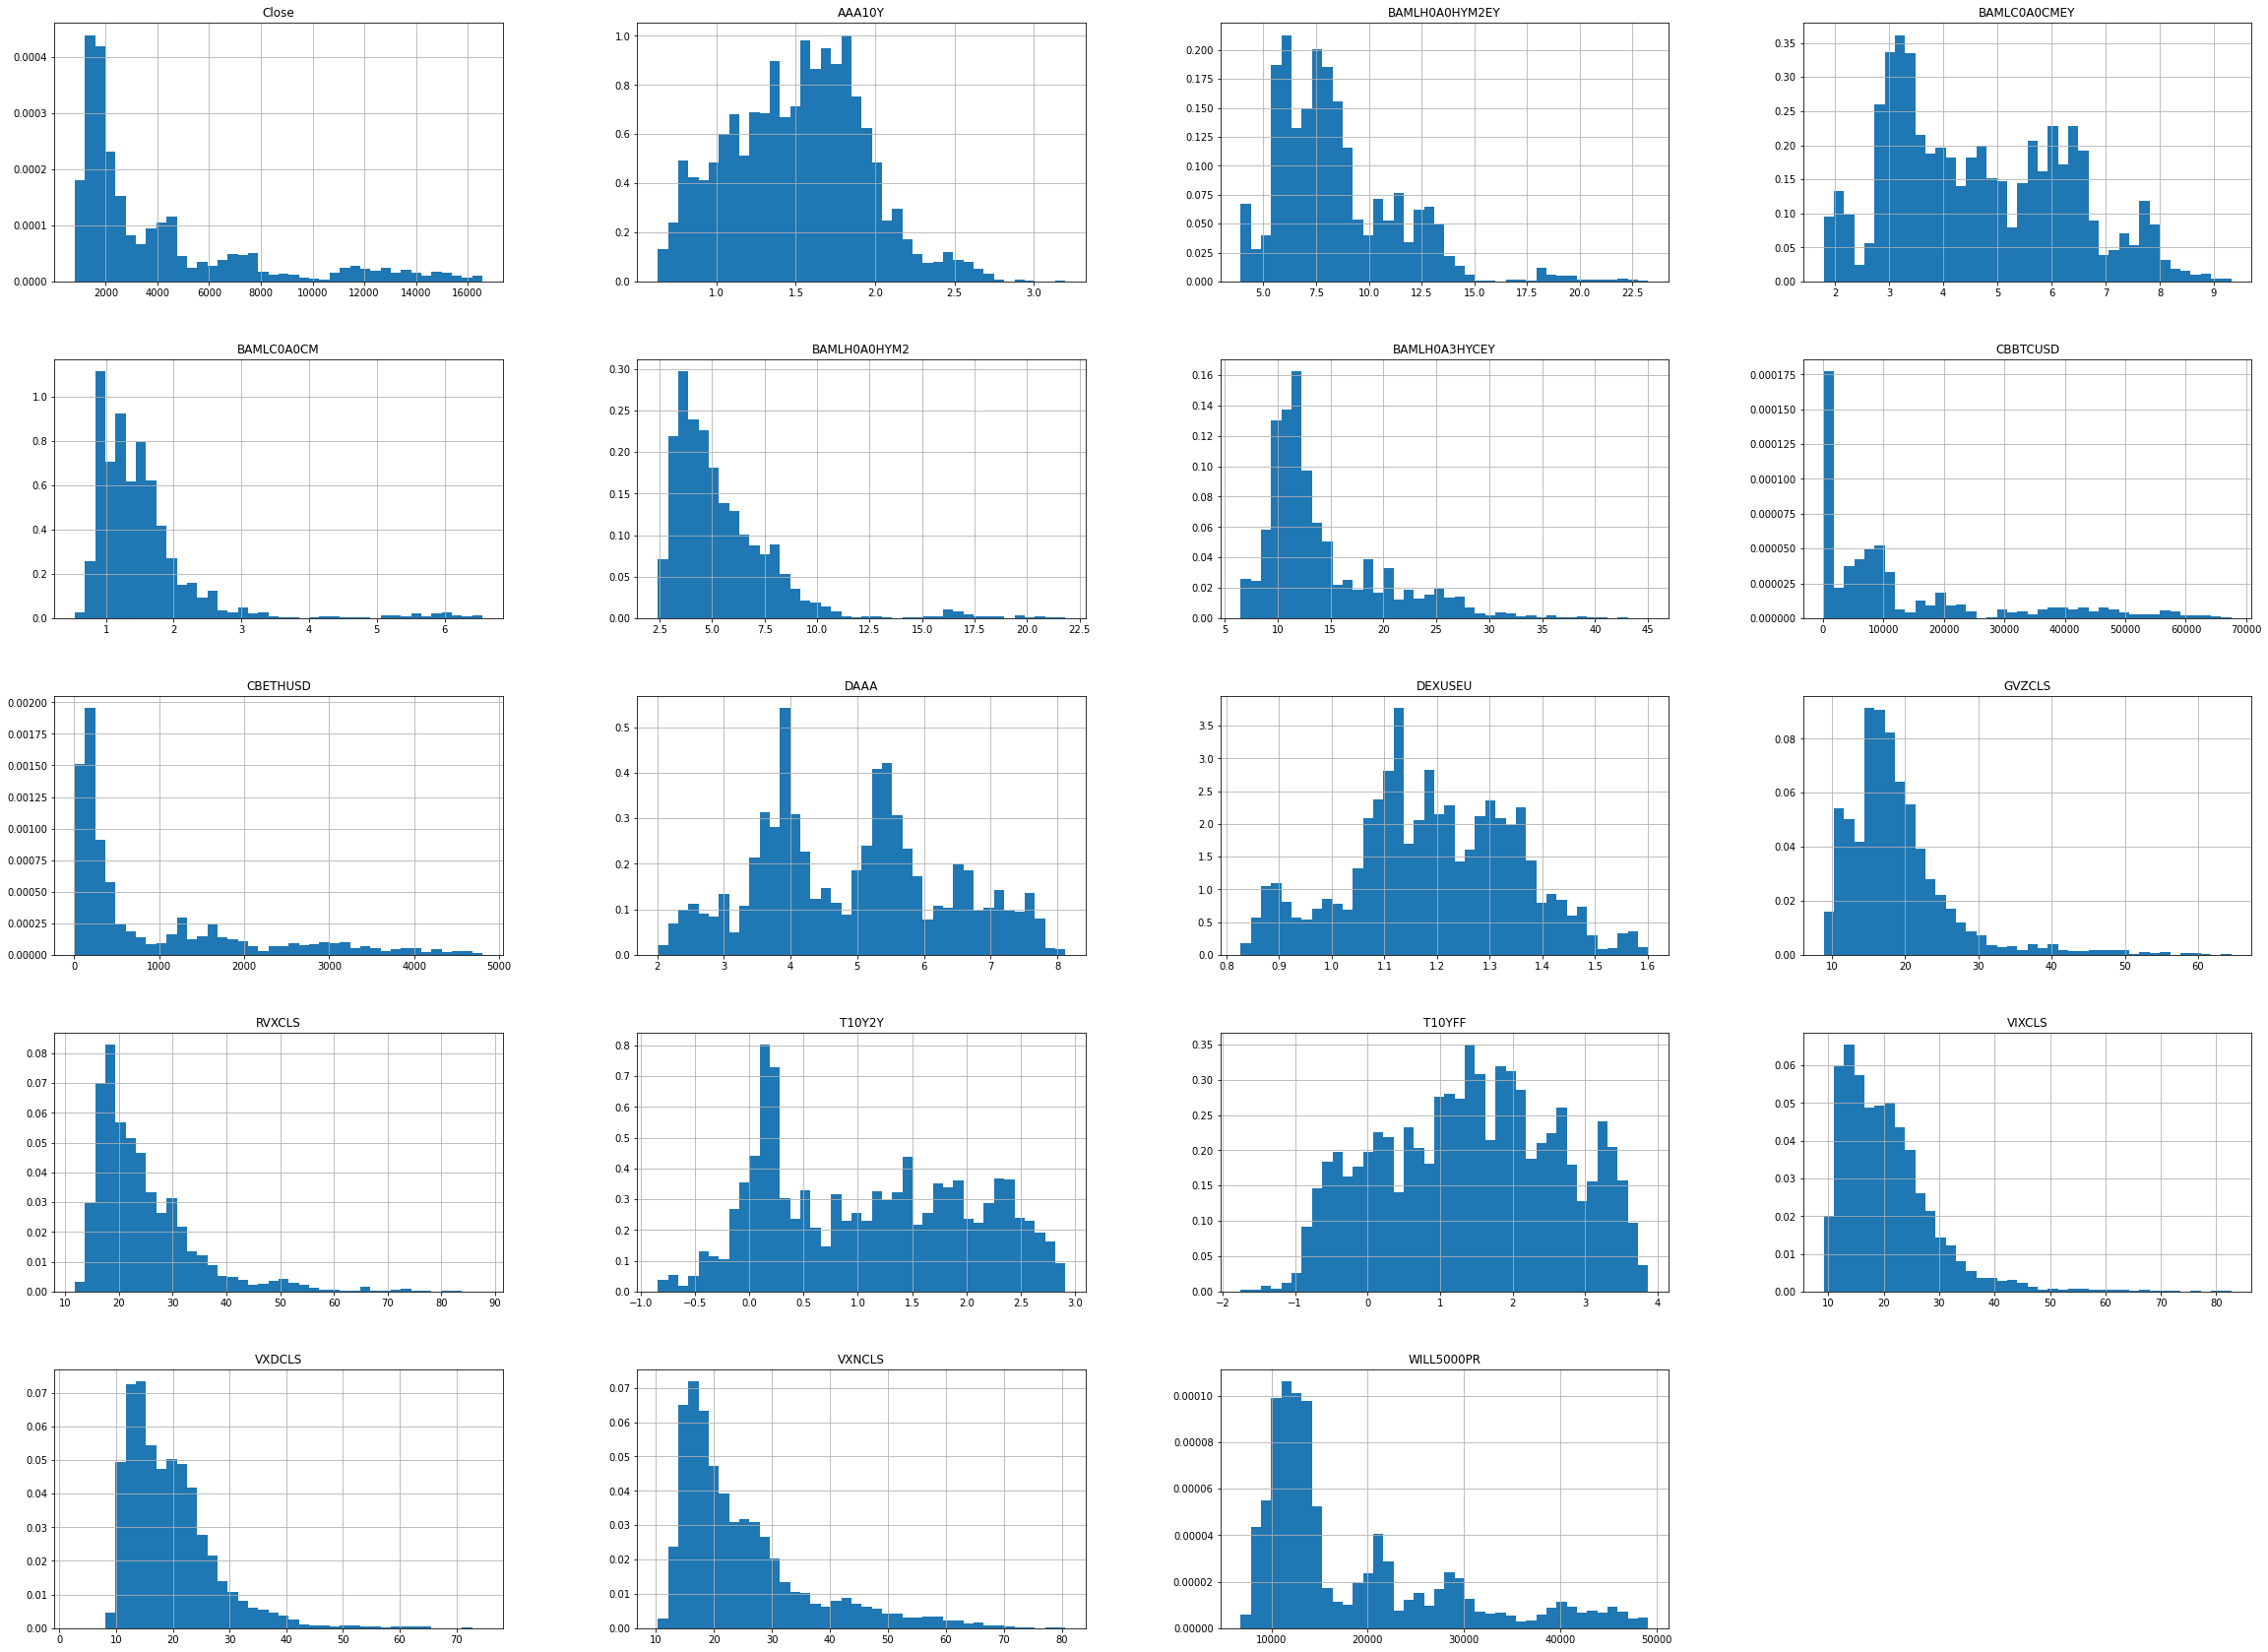

In [16]:
df_agg.drop(columns=["Date"]).hist(figsize=(40,30),bins=40, density=True)

In [17]:
matrix = df_agg.drop(columns=["Date"]).corr()

<AxesSubplot:>

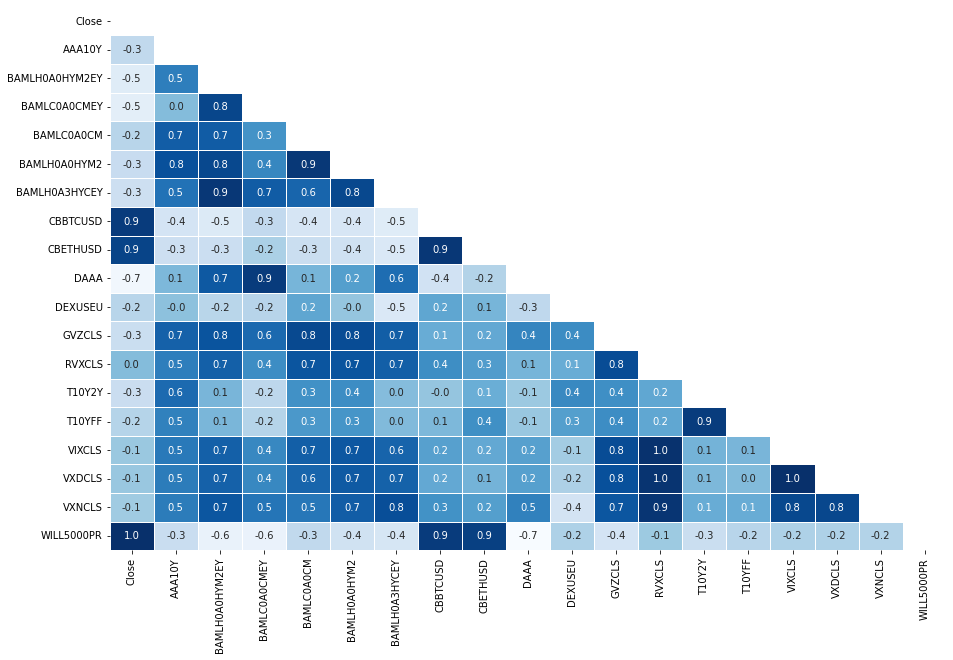

In [18]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [19]:
predictors_df = pps.predictors(df_agg.drop(columns=["Date"]), y='Close')
predictors_df

x      y   ppscore        case  is_valid_score  \
0       WILL5000PR  Close  0.848286  regression            True   
1         CBBTCUSD  Close  0.753433  regression            True   
2         CBETHUSD  Close  0.644623  regression            True   
3             DAAA  Close  0.486888  regression            True   
4     BAMLC0A0CMEY  Close  0.350953  regression            True   
5   BAMLH0A0HYM2EY  Close  0.319079  regression            True   
6           T10Y2Y  Close  0.111197  regression            True   
7           AAA10Y  Close  0.085603  regression            True   
8    BAMLH0A3HYCEY  Close  0.065223  regression            True   
9       BAMLC0A0CM  Close  0.053823  regression            True   
10    BAMLH0A0HYM2  Close  0.034171  regression            True   
11          T10YFF  Close  0.023738  regression            True   
12         DEXUSEU  Close  0.021042  regression            True   
13          GVZCLS  Close  0.000000  regression            True   
14          RVXCLS  Close  0.000000  regression            True   
15          VIXCLS  Close  0.000000  regression            True   
16          VXDCLS  Close  0.000000  regression            True   
17          VXNCLS  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error     2482.426700   376.618959  DecisionTreeRegressor()  
1   mean absolute error     2988.785160   736.936095  DecisionTreeRegressor()  
2   mean absolute error     2946.705857  1047.192147  DecisionTreeRegressor()  
3   mean absolute error     2482.426700  1273.761969  DecisionTreeRegressor()  
4   mean absolute error     2482.426700  1611.212158  DecisionTreeRegressor()  
5   mean absolute error     2482.426700  1690.335850  DecisionTreeRegressor()  
6   mean absolute error     2482.426700  2206.388916  DecisionTreeRegressor()  
7   mean absolute error     2482.426700  2269.923839  DecisionTreeRegressor()  
8   mean absolute error     2482.426700  2320.514580  DecisionTreeRegressor()  
9   mean absolute error     2482.426700  2348.814707  DecisionTreeRegressor()  
10  mean absolute error     2482.426700  2397.599596  DecisionTreeRegressor()  
11  mean absolute error     2482.426700  2423.498098  DecisionTreeRegressor()  
12  mean absolute error     2522.451339  2469.373274  DecisionTreeRegressor()  
13  mean absolute error     3105.133731  3276.784011  DecisionTreeRegressor()  
14  mean absolute error     2902.279338  3335.417216  DecisionTreeRegressor()  
15  mean absolute error     2482.426700  3147.386119  DecisionTreeRegressor()  
16  mean absolute error     2482.426700  3193.890348  DecisionTreeRegressor()  
17  mean absolute error     2702.999010  3107.215254  DecisionTreeRegressor()

[Text(0, 0, '0.848286'),
 Text(0, 0, '0.753433'),
 Text(0, 0, '0.644623'),
 Text(0, 0, '0.486888'),
 Text(0, 0, '0.350953'),
 Text(0, 0, '0.319079'),
 Text(0, 0, '0.111197'),
 Text(0, 0, '0.0856029'),
 Text(0, 0, '0.0652233'),
 Text(0, 0, '0.0538231'),
 Text(0, 0, '0.034171'),
 Text(0, 0, '0.0237383'),
 Text(0, 0, '0.0210423'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

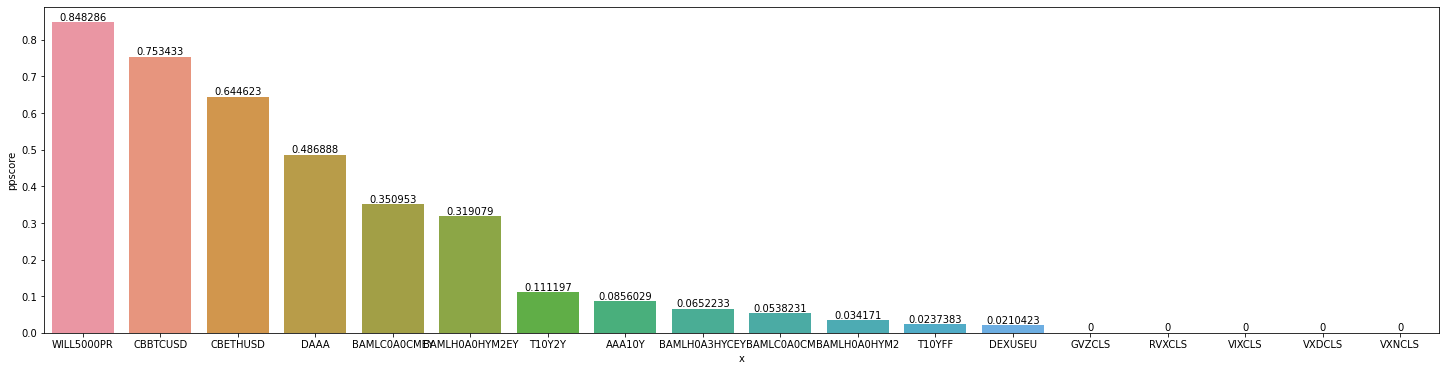

In [20]:
plt.figure(figsize=(25,6))
ax = sns.barplot(data=predictors_df, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

## Données normalisées
On va étudier ici les variations en % par rapport au résultat de la veille, plutôt que les valeurs brutes, puis en Ln, et enfin converti en base 1000

### En %

In [21]:
def daily_var(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( ((df_dailyR[col] - df_dailyR[col].shift(1))/df_dailyR[col].shift(1))*100, 2)
  
  return df_dailyR

In [22]:
df_norm = daily_var(df_agg)
df_norm.dropna(subset=['Close'], inplace=True)
df_norm.reset_index(drop=True, inplace=True)
df_norm.head()

Date  Close  AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLC0A0CM  \
0 1997-10-08   0.40    0.00            0.00          1.83        0.00   
1 1997-10-09   0.25    1.05            0.46          0.30        0.00   
2 1997-10-10  -0.91   -2.08            0.00          1.49       18.52   
3 1997-10-13   0.24    1.06            0.34          0.00        0.00   
4 1997-10-14  -0.79    1.05           -0.34         -1.47      -15.62   

   BAMLH0A0HYM2  BAMLH0A3HYCEY  CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  \
0         -4.96          -0.43       NaN       NaN  2.03      NaN     NaN   
1          0.80           0.26       NaN       NaN  0.28      NaN     NaN   
2          0.00           0.09       NaN       NaN  0.57      NaN     NaN   
3          1.20           0.00       NaN       NaN -0.42      NaN     NaN   
4         -1.18          -0.17       NaN       NaN -0.42      NaN     NaN   

   RVXCLS  T10Y2Y  T10YFF  VIXCLS  VXDCLS  VXNCLS  WILL5000PR  
0     NaN    7.41    7.69    2.37    0.65     NaN       -0.68  
1     NaN    0.00   14.29    7.41    0.65     NaN       -0.13  
2     NaN    0.00   21.88  -11.47   -0.60     NaN       -0.27  
3     NaN   -5.17  -20.51    2.58    3.24     NaN        0.13  
4     NaN   -5.45  -25.81   -1.33   -0.81     NaN        0.07

In [23]:
df_norm.describe()

Close       AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY   BAMLC0A0CM  \
count  6622.000000  6622.000000     6622.000000   6622.000000  6622.000000   
mean      0.050969     0.019633        0.004407      0.003229     0.022546   
std       1.746392     2.111912        0.970321      1.096216     1.391996   
min     -12.190000   -22.220000       -9.750000     -7.370000   -19.050000   
25%      -0.687500    -1.050000       -0.380000     -0.630000    -0.630000   
50%       0.110000     0.000000        0.000000      0.000000     0.000000   
75%       0.820000     1.020000        0.290000      0.580000     0.527500   
max      18.770000    18.520000       14.350000     14.250000    27.000000   

       BAMLH0A0HYM2  BAMLH0A3HYCEY    CBBTCUSD     CBETHUSD         DAAA  \
count   6622.000000    6622.000000  2148.00000  1766.000000  6622.000000   
mean       0.021226       0.008766     0.31129     0.488562     0.001583   
std        1.668429       1.070140     4.81527     6.607190     1.224177   
min       -9.650000     -12.160000   -53.85000   -43.090000   -13.350000   
25%       -0.897500      -0.420000    -1.55000    -2.590000    -0.610000   
50%        0.000000      -0.040000     0.20000     0.065000     0.000000   
75%        0.800000       0.350000     2.10250     3.287500     0.590000   
max       18.440000      11.820000    70.18000    49.170000    18.060000   

           DEXUSEU       GVZCLS       RVXCLS   T10Y2Y   T10YFF       VIXCLS  \
count  6298.000000  3842.000000  4994.000000  6617.00  6622.00  6622.000000   
mean     -0.000086     0.129081     0.161856      NaN      NaN     0.237122   
std       0.571951     5.421401     5.780053      NaN      NaN     7.102834   
min      -2.960000   -35.980000   -30.530000     -inf     -inf   -29.570000   
25%      -0.310000    -2.960000    -3.237500    -2.13    -2.88    -3.760000   
50%      -0.010000    -0.380000    -0.250000     0.00     0.00    -0.370000   
75%       0.310000     2.500000     2.857500     2.07     2.80     3.310000   
max       4.730000    61.730000    71.680000      inf      inf   115.600000   

            VXDCLS       VXNCLS   WILL5000PR  
count  6622.000000  5754.000000  6622.000000  
mean      0.263058     0.158665     0.029551  
std       8.818485     5.978173     1.222006  
min     -81.760000   -26.880000   -12.290000  
25%      -3.480000    -3.180000    -0.470000  
50%      -0.270000    -0.280000     0.060000  
75%       3.040000     2.810000     0.590000  
max     472.320000    59.830000    11.380000

In [24]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_norm.copy()
df_hist.drop(columns=['Date','T10Y2Y','T10YFF'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [25]:
matrix_norm = df_norm.drop(columns=["Date"]).corr()

<AxesSubplot:>

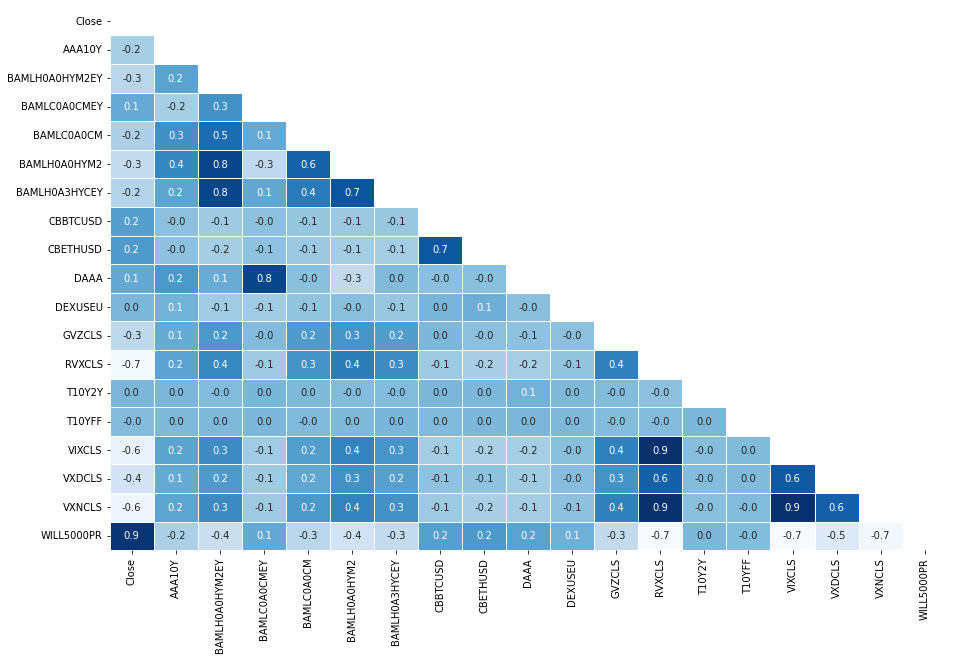

In [26]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_norm, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_norm, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

En données normalisées : 
<li>WILL5000 reste très corrélé</li>
<li>BTC & ETH ne le sont plus ?!</li>
<li>VXNCLS & VXDCLS & RVXCLS* le deviennent, négativement. Ce qui est attendu pour le VIX</li>
<i>* volatilité du Russell 2000

In [27]:
predictors_df_norm = pps.predictors(df_norm.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_norm

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce



x      y   ppscore           case  is_valid_score  \
0       WILL5000PR  Close  0.455736     regression            True   
1           RVXCLS  Close  0.067960     regression            True   
2           VXNCLS  Close  0.017968     regression            True   
3           AAA10Y  Close  0.000000     regression            True   
4   BAMLH0A0HYM2EY  Close  0.000000     regression            True   
5     BAMLC0A0CMEY  Close  0.000000     regression            True   
6       BAMLC0A0CM  Close  0.000000     regression            True   
7     BAMLH0A0HYM2  Close  0.000000     regression            True   
8    BAMLH0A3HYCEY  Close  0.000000     regression            True   
9         CBBTCUSD  Close  0.000000     regression            True   
10        CBETHUSD  Close  0.000000     regression            True   
11            DAAA  Close  0.000000     regression            True   
12         DEXUSEU  Close  0.000000     regression            True   
13          GVZCLS  Close  0.000000     regression            True   
14          T10YFF  Close  0.000000  unknown_error           False   
15          VIXCLS  Close  0.000000     regression            True   
16          VXDCLS  Close  0.000000     regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        1.174638     0.639313  DecisionTreeRegressor()  
1   mean absolute error        0.919890     0.857375  DecisionTreeRegressor()  
2   mean absolute error        1.053732     1.034799  DecisionTreeRegressor()  
3   mean absolute error        1.174638     1.376614  DecisionTreeRegressor()  
4   mean absolute error        1.174638     1.249939  DecisionTreeRegressor()  
5   mean absolute error        1.174638     1.327551  DecisionTreeRegressor()  
6   mean absolute error        1.174638     1.289794  DecisionTreeRegressor()  
7   mean absolute error        1.174638     1.300392  DecisionTreeRegressor()  
8   mean absolute error        1.174638     1.277927  DecisionTreeRegressor()  
9   mean absolute error        0.942975     1.300354  DecisionTreeRegressor()  
10  mean absolute error        0.970351     1.384193  DecisionTreeRegressor()  
11  mean absolute error        1.174638     1.333654  DecisionTreeRegressor()  
12  mean absolute error        1.152560     1.263938  DecisionTreeRegressor()  
13  mean absolute error        0.947543     1.240401  DecisionTreeRegressor()  
14                 None        0.000000     0.000000                     None  
15  mean absolute error        1.174638     1.210314  DecisionTreeRegressor()  
16  mean absolute error        1.174638     1.275867  DecisionTreeRegressor()

[Text(0, 0, '0.455736'),
 Text(0, 0, '0.0679595'),
 Text(0, 0, '0.0179677'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

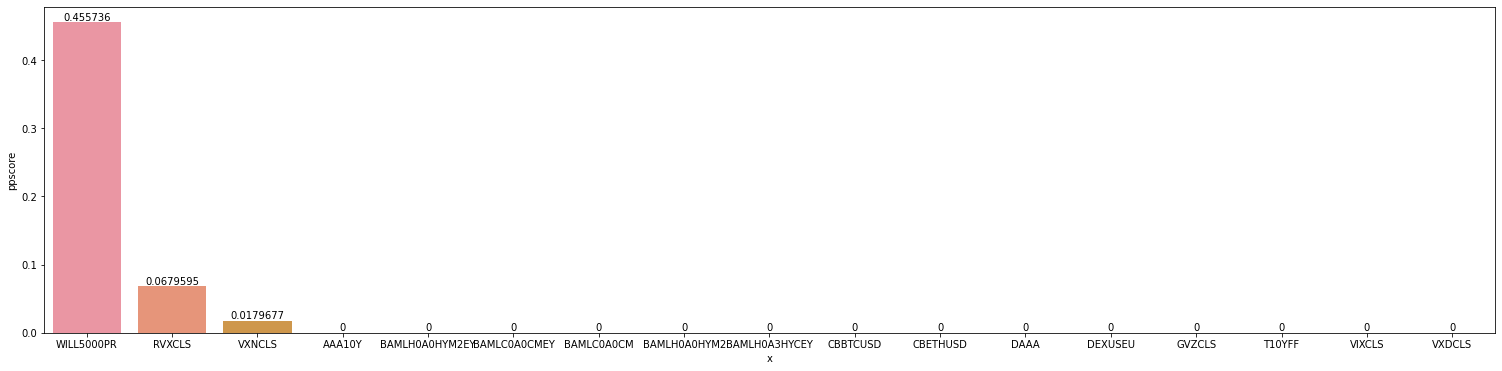

In [28]:
plt.figure(figsize=(26,6))
ax = sns.barplot(data=predictors_df_norm, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En Ln (résulats identiques à %)

In [29]:
def daily_var_ln(df):
  ''' variation par rapport à la valeur de la veille, en %'''

  df_dailyR = df.copy()
  col_list = df_dailyR.columns[1:]

  for col in col_list:
    df_dailyR[col] = round( np.log(df_dailyR[col]/df_dailyR[col].shift(1)), 2)
  
  return df_dailyR

In [30]:
df_Ln = daily_var(df_agg)
df_Ln.dropna(subset=['Close'], inplace=True)
df_Ln.reset_index(drop=True, inplace=True)
df_Ln.head()

Date  Close  AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLC0A0CM  \
0 1997-10-08   0.40    0.00            0.00          1.83        0.00   
1 1997-10-09   0.25    1.05            0.46          0.30        0.00   
2 1997-10-10  -0.91   -2.08            0.00          1.49       18.52   
3 1997-10-13   0.24    1.06            0.34          0.00        0.00   
4 1997-10-14  -0.79    1.05           -0.34         -1.47      -15.62   

   BAMLH0A0HYM2  BAMLH0A3HYCEY  CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  \
0         -4.96          -0.43       NaN       NaN  2.03      NaN     NaN   
1          0.80           0.26       NaN       NaN  0.28      NaN     NaN   
2          0.00           0.09       NaN       NaN  0.57      NaN     NaN   
3          1.20           0.00       NaN       NaN -0.42      NaN     NaN   
4         -1.18          -0.17       NaN       NaN -0.42      NaN     NaN   

   RVXCLS  T10Y2Y  T10YFF  VIXCLS  VXDCLS  VXNCLS  WILL5000PR  
0     NaN    7.41    7.69    2.37    0.65     NaN       -0.68  
1     NaN    0.00   14.29    7.41    0.65     NaN       -0.13  
2     NaN    0.00   21.88  -11.47   -0.60     NaN       -0.27  
3     NaN   -5.17  -20.51    2.58    3.24     NaN        0.13  
4     NaN   -5.45  -25.81   -1.33   -0.81     NaN        0.07

In [31]:
# Group all data returns together in a list
# Make a copy of the daily returns dataframe
df_hist = df_Ln.copy()
df_hist.drop(columns=['Date','T10Y2Y','T10YFF'],inplace=True)
df_hist.dropna(inplace=True)

l_hist=[]
[l_hist.append(df_hist[i].values) for i in df_hist.columns]
len(l_hist)

# Plotly's Python API contains a super pwerful module known as figure factory module 
fig = ff.create_distplot(l_hist, df_hist.columns)
fig.show()

In [32]:
matrix_Ln = df_Ln.drop(columns=["Date"]).corr()

<AxesSubplot:>

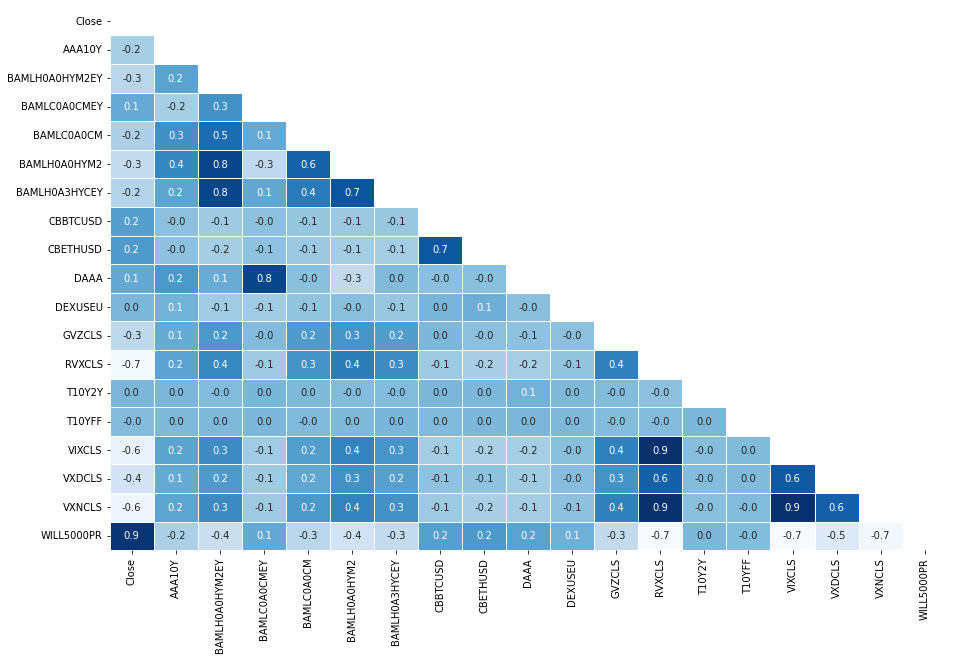

In [33]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_Ln, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_Ln, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [34]:
predictors_df_Ln = pps.predictors(df_Ln.drop(columns=["Date","T10Y2Y"]), y='Close')
predictors_df_Ln

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

invalid value encountered in reduce



x      y   ppscore           case  is_valid_score  \
0       WILL5000PR  Close  0.455736     regression            True   
1           RVXCLS  Close  0.067960     regression            True   
2           VXNCLS  Close  0.017968     regression            True   
3           AAA10Y  Close  0.000000     regression            True   
4   BAMLH0A0HYM2EY  Close  0.000000     regression            True   
5     BAMLC0A0CMEY  Close  0.000000     regression            True   
6       BAMLC0A0CM  Close  0.000000     regression            True   
7     BAMLH0A0HYM2  Close  0.000000     regression            True   
8    BAMLH0A3HYCEY  Close  0.000000     regression            True   
9         CBBTCUSD  Close  0.000000     regression            True   
10        CBETHUSD  Close  0.000000     regression            True   
11            DAAA  Close  0.000000     regression            True   
12         DEXUSEU  Close  0.000000     regression            True   
13          GVZCLS  Close  0.000000     regression            True   
14          T10YFF  Close  0.000000  unknown_error           False   
15          VIXCLS  Close  0.000000     regression            True   
16          VXDCLS  Close  0.000000     regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        1.174638     0.639313  DecisionTreeRegressor()  
1   mean absolute error        0.919890     0.857375  DecisionTreeRegressor()  
2   mean absolute error        1.053732     1.034799  DecisionTreeRegressor()  
3   mean absolute error        1.174638     1.376614  DecisionTreeRegressor()  
4   mean absolute error        1.174638     1.249939  DecisionTreeRegressor()  
5   mean absolute error        1.174638     1.327551  DecisionTreeRegressor()  
6   mean absolute error        1.174638     1.289794  DecisionTreeRegressor()  
7   mean absolute error        1.174638     1.300392  DecisionTreeRegressor()  
8   mean absolute error        1.174638     1.277927  DecisionTreeRegressor()  
9   mean absolute error        0.942975     1.300354  DecisionTreeRegressor()  
10  mean absolute error        0.970351     1.384193  DecisionTreeRegressor()  
11  mean absolute error        1.174638     1.333654  DecisionTreeRegressor()  
12  mean absolute error        1.152560     1.263938  DecisionTreeRegressor()  
13  mean absolute error        0.947543     1.240401  DecisionTreeRegressor()  
14                 None        0.000000     0.000000                     None  
15  mean absolute error        1.174638     1.210314  DecisionTreeRegressor()  
16  mean absolute error        1.174638     1.275867  DecisionTreeRegressor()

[Text(0, 0, '0.455736'),
 Text(0, 0, '0.0679595'),
 Text(0, 0, '0.0179677'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

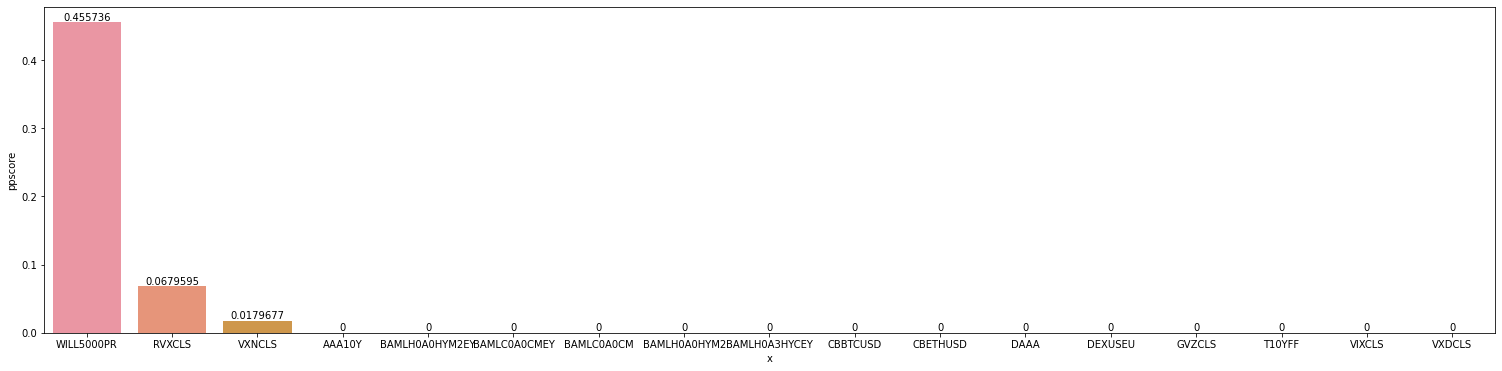

In [35]:
plt.figure(figsize=(26,6))
ax = sns.barplot(data=predictors_df_Ln, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### En base 1000

In [36]:
# Fonction pour normaliser les valeurs base 1000
def normalize(df):
  df_norm = df.copy()
  col_list = df.columns
  for element in col_list[1:]:
    df_norm[element] = df_norm[element].apply(lambda x: (x/(df_norm.loc[0,element])*1000))
  return df_norm

In [37]:
# Fonction de visualisation avec Plotly
def interactif_plot(df, titre):
  fig = px.line(title = titre)

  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name =i)

  fig.show()

In [38]:
df_base1000 = df_agg.dropna()
df_base1000.reset_index(drop=True, inplace=True)

In [39]:
df_base1000 = normalize(df_base1000)
interactif_plot(df_base1000,'Variation base 1000')

In [40]:
matrix_1000 = df_base1000.drop(columns=["Date"]).corr()

<AxesSubplot:>

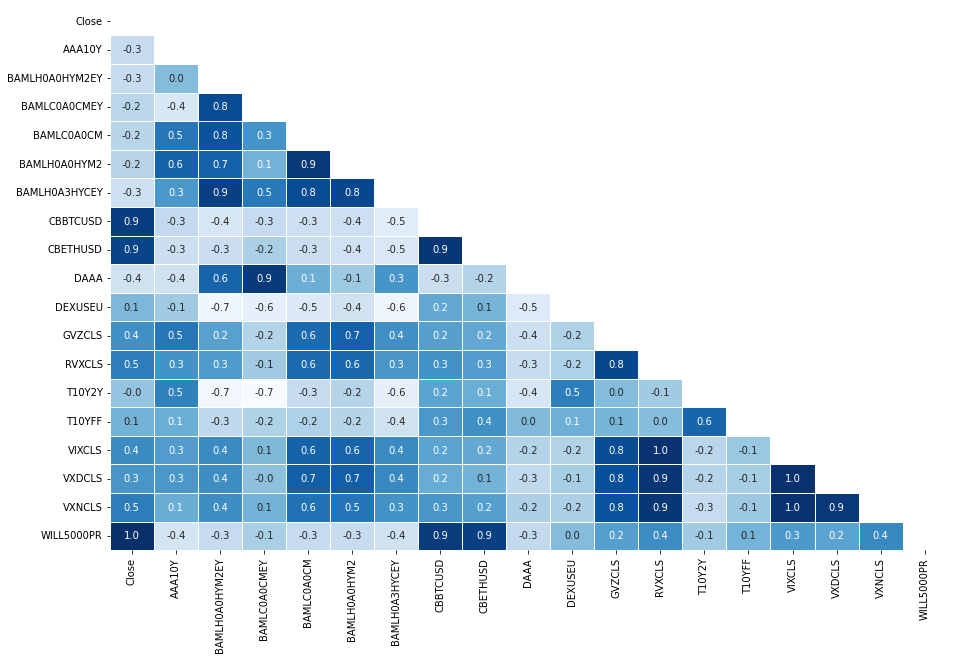

In [41]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_1000, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(matrix_1000, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

Ne présente pas d'intérêt, voire même fausse l'utilisation des données de volatilité ?

In [42]:
predictors_df_base1000 = pps.predictors(df_base1000.drop(columns=["Date"]), y='Close')
predictors_df_base1000

x      y   ppscore        case  is_valid_score  \
0       WILL5000PR  Close  0.849640  regression            True   
1         CBBTCUSD  Close  0.702593  regression            True   
2         CBETHUSD  Close  0.645023  regression            True   
3     BAMLC0A0CMEY  Close  0.485765  regression            True   
4   BAMLH0A0HYM2EY  Close  0.390811  regression            True   
5             DAAA  Close  0.377308  regression            True   
6    BAMLH0A3HYCEY  Close  0.349881  regression            True   
7           RVXCLS  Close  0.329074  regression            True   
8       BAMLC0A0CM  Close  0.225237  regression            True   
9           VXNCLS  Close  0.222941  regression            True   
10          T10Y2Y  Close  0.211721  regression            True   
11          VIXCLS  Close  0.202258  regression            True   
12    BAMLH0A0HYM2  Close  0.193754  regression            True   
13          T10YFF  Close  0.153172  regression            True   
14          VXDCLS  Close  0.145856  regression            True   
15          GVZCLS  Close  0.143997  regression            True   
16          AAA10Y  Close  0.078835  regression            True   
17         DEXUSEU  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error      679.241501   102.130440  DecisionTreeRegressor()  
1   mean absolute error      679.241501   202.011491  DecisionTreeRegressor()  
2   mean absolute error      679.241501   241.114946  DecisionTreeRegressor()  
3   mean absolute error      679.241501   349.289910  DecisionTreeRegressor()  
4   mean absolute error      679.241501   413.786333  DecisionTreeRegressor()  
5   mean absolute error      679.241501   422.958509  DecisionTreeRegressor()  
6   mean absolute error      679.241501   441.587698  DecisionTreeRegressor()  
7   mean absolute error      679.241501   455.721024  DecisionTreeRegressor()  
8   mean absolute error      679.241501   526.251214  DecisionTreeRegressor()  
9   mean absolute error      679.241501   527.810844  DecisionTreeRegressor()  
10  mean absolute error      679.241501   535.431964  DecisionTreeRegressor()  
11  mean absolute error      679.241501   541.859725  DecisionTreeRegressor()  
12  mean absolute error      679.241501   547.635670  DecisionTreeRegressor()  
13  mean absolute error      679.241501   575.200799  DecisionTreeRegressor()  
14  mean absolute error      679.241501   580.170087  DecisionTreeRegressor()  
15  mean absolute error      679.241501   581.433013  DecisionTreeRegressor()  
16  mean absolute error      679.241501   625.693417  DecisionTreeRegressor()  
17  mean absolute error      679.241501   695.329319  DecisionTreeRegressor()

[Text(0, 0, '0.84964'),
 Text(0, 0, '0.702593'),
 Text(0, 0, '0.645023'),
 Text(0, 0, '0.485765'),
 Text(0, 0, '0.390811'),
 Text(0, 0, '0.377308'),
 Text(0, 0, '0.349881'),
 Text(0, 0, '0.329074'),
 Text(0, 0, '0.225237'),
 Text(0, 0, '0.222941'),
 Text(0, 0, '0.211721'),
 Text(0, 0, '0.202258'),
 Text(0, 0, '0.193754'),
 Text(0, 0, '0.153172'),
 Text(0, 0, '0.145856'),
 Text(0, 0, '0.143997'),
 Text(0, 0, '0.0788351'),
 Text(0, 0, '0')]

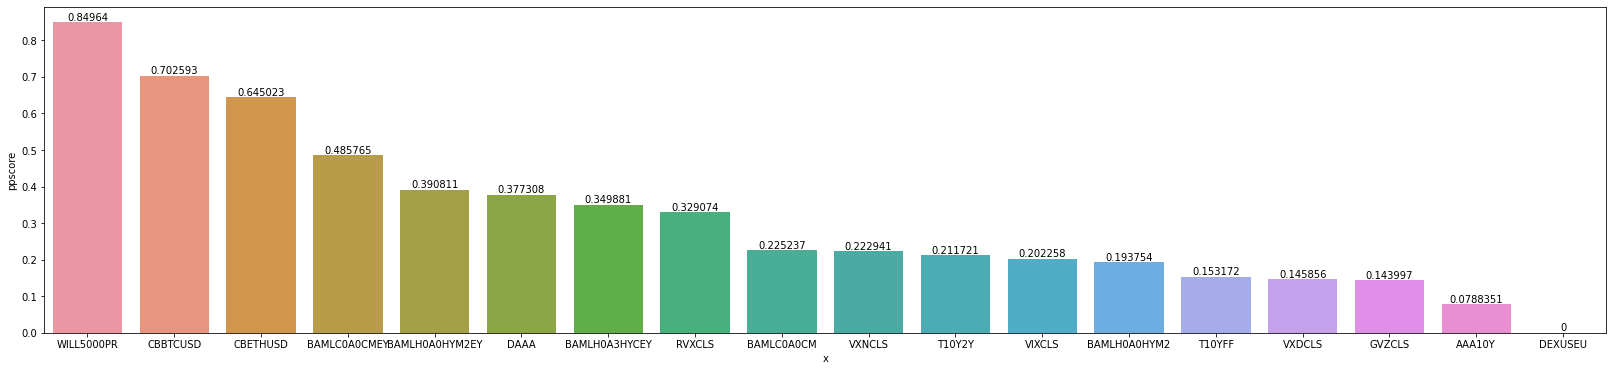

In [43]:
plt.figure(figsize=(28,6))
ax = sns.barplot(data=predictors_df_base1000, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

Ici le résultat est globalement identique pour le Top 3, quoi que moins bon score, comparativement entre base 1000 et mesures brutes.<br>
L'augmentation est significative pour les données BAML**** (corporate yield indexes)

# BTC, ETH & WILL5000 shift

## ACF, PACF

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf

Colonnes selectionnées compte-tenu des correlations & PPS ci-dessus :
<li>Brute : WILL5000, BTC, ETH, DAAA (df_agg)</li>
<li>% ou Ln : RVXCLS, VXNCLS, VIXCLS (df_norm)</li>
<li>Base 1000 : BAML*****EY, 3 colonnes (df_base1000)</li>

In [45]:
df_agg.columns

Index(['Date', 'Close', 'AAA10Y', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY',
       'BAMLC0A0CM', 'BAMLH0A0HYM2', 'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD',
       'DAAA', 'DEXUSEU', 'GVZCLS', 'RVXCLS', 'T10Y2Y', 'T10YFF', 'VIXCLS',
       'VXDCLS', 'VXNCLS', 'WILL5000PR'],
      dtype='object')

In [46]:
df_shifted = df_agg[["Date","Close","CBBTCUSD","CBETHUSD","DAAA","WILL5000PR"]].merge(df_norm[["Date","RVXCLS","VIXCLS","VXNCLS"]], how='left', on='Date')
df_shifted = df_shifted.merge(df_base1000[["Date","BAMLH0A0HYM2EY","BAMLC0A0CMEY","BAMLH0A3HYCEY"]], how='left', on='Date')

In [48]:
df_shifted.head(1)
#df_shifted.dropna(inplace=True)
#df_shifted.reset_index(drop=True, inplace=True)

Date    Close  CBBTCUSD  CBETHUSD  DAAA  WILL5000PR  RVXCLS  VIXCLS  \
0 1997-10-07  1140.74       NaN       NaN  6.89     9486.69     NaN     NaN   

   VXNCLS  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLH0A3HYCEY  
0     NaN             NaN           NaN            NaN

In [50]:
df_shifted.tail(1)

Date     Close  CBBTCUSD  CBETHUSD  DAAA  WILL5000PR  RVXCLS  \
6622 2023-02-23  12180.14  23938.48    1649.7  4.68    40922.81   -4.11   

      VIXCLS  VXNCLS  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLH0A3HYCEY  
6622   -5.16   -4.25     1114.023591    1723.27044     879.120879

In [51]:
def difference_veille(df):
# Soustrait la valeur de la veille pour rendre la série stationnaire
  df_diff = df.copy()
  col_list = df_diff.columns
  for element in col_list[1:]:
    df_diff[element] = df_diff[element] - df_diff[element].shift(1)
  return df_diff

In [52]:
df_stationnary = difference_veille(df_shifted)

In [70]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
        return True
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        return False

In [74]:
res = check_stationarity(df_stationnary["Close"].dropna())

ADF Statistic: -15.572693
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


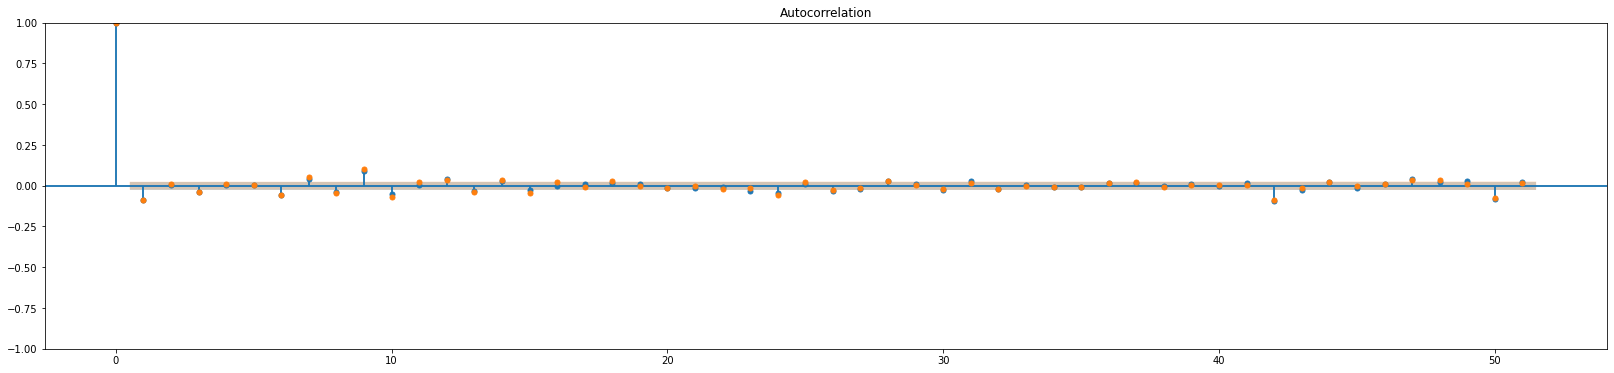

In [55]:
# Cloture
fig, ax = plt.subplots(figsize=(28, 6))
plot_pacf(df_stationnary["Close"].dropna(), lags=51, ax=ax, method='ywm')
plot_acf(df_stationnary["Close"].dropna(), lags=51, ax=ax)
plt.show()

In [58]:
df_pacf = pd.DataFrame(pacf(df_stationnary["Close"].dropna(), nlags=51, method='ywm'), columns=["pacf_value"])
df_pacf["abs_values"] = df_pacf["pacf_value"].abs()

In [60]:
df_pacf.sort_values(by=["abs_values"], ascending=False).head(6)

pacf_value  abs_values
0     1.000000    1.000000
42   -0.092717    0.092717
9     0.092252    0.092252
1    -0.088477    0.088477
50   -0.079192    0.079192
6    -0.057238    0.057238

In [64]:
best_lags = df_pacf.sort_values(by=["abs_values"], ascending=False)\
            .head(6)\
            .index\
            .to_list()
print(best_lags[1:])

[42, 9, 1, 50, 6]


appplication du principe suivant pour les autres colonnes

In [69]:
# Récupération de la liste des colonnes identifiées comme à plus forte correlation avec Close
pacs_cols = df_stationnary.columns.to_list()
print(pacs_cols[1:])

['Close', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'WILL5000PR', 'RVXCLS', 'VIXCLS', 'VXNCLS', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY', 'BAMLH0A3HYCEY']


In [82]:
d_lags = {}

for colonne in pacs_cols[1:]:
  # Vérifie si la colonne est stationnaire
  res = check_stationarity(df_stationnary[colonne].dropna())
  # Si stationnaire, on stocke les 5 lags les plus significatifs, y compris lag 1
  if res :
    df_pacf = pd.DataFrame(pacf(df_stationnary[colonne].dropna(), nlags=51, method='ywm'), columns=["pacf_value"])
    df_pacf["abs_values"] = df_pacf["pacf_value"].abs()

    best_lags = df_pacf.sort_values(by=["abs_values"], ascending=False)\
            .head(4)\
            .index\
            .to_list()
    #Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
    d_lags[colonne] = best_lags[1:4]
  
  else :
    print("{} colonne non stationnaire".format(colonne))

ADF Statistic: -15.572693
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -7.705974
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary
ADF Statistic: -7.047812
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary
ADF Statistic: -17.096288
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -15.927058
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -20.214740
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -23.349356
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -22.005876
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
ADF Statistic: -8.944667
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary
ADF Statistic: -19.100

#### Conclusion
Ci après les Lags à générer par colonnes, Top 3<br>
exclusion de l'élement 0 qui est la corrélation de la série avec elle-même.<br>
A noter que l'<b>ordre est par plus forte corrélation</b>, et non par ordre croissant d'index.

In [83]:
d_lags

{'Close': [42, 9, 1],
 'CBBTCUSD': [5, 7, 3],
 'CBETHUSD': [1, 24, 10],
 'DAAA': [9, 23, 16],
 'WILL5000PR': [9, 1, 6],
 'RVXCLS': [1, 2, 3],
 'VIXCLS': [1, 2, 3],
 'VXNCLS': [1, 2, 3],
 'BAMLH0A0HYM2EY': [1, 2, 13],
 'BAMLC0A0CMEY': [1, 2, 3],
 'BAMLH0A3HYCEY': [1, 2, 9]}

## Génération des colonnes identifiées

### Shifted columns

In [85]:
df_shifted.head(1)

Date    Close  CBBTCUSD  CBETHUSD  DAAA  WILL5000PR  RVXCLS  VIXCLS  \
0 1997-10-07  1140.74       NaN       NaN  6.89     9486.69     NaN     NaN   

   VXNCLS  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLH0A3HYCEY  
0     NaN             NaN           NaN            NaN

In [92]:
for k in d_lags.keys() :
  for i in range (0,3):
    # Récupère les meilleurs lags de chaque colonne
    lag = d_lags[k][i]
    # Génère les shifted cols correspondantes
    df_shifted[k+"_lag"+str(lag)] = df_shifted[k].shift(lag)

In [94]:
df_shifted.columns

Index(['Date', 'Close', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'WILL5000PR', 'RVXCLS',
       'VIXCLS', 'VXNCLS', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY', 'BAMLH0A3HYCEY',
       'Close_lag42', 'Close_lag9', 'Close_lag1', 'CBBTCUSD_lag5',
       'CBBTCUSD_lag7', 'CBBTCUSD_lag3', 'CBETHUSD_lag1', 'CBETHUSD_lag24',
       'CBETHUSD_lag10', 'DAAA_lag9', 'DAAA_lag23', 'DAAA_lag16',
       'WILL5000PR_lag9', 'WILL5000PR_lag1', 'WILL5000PR_lag6', 'RVXCLS_lag1',
       'RVXCLS_lag2', 'RVXCLS_lag3', 'VIXCLS_lag1', 'VIXCLS_lag2',
       'VIXCLS_lag3', 'VXNCLS_lag1', 'VXNCLS_lag2', 'VXNCLS_lag3',
       'BAMLH0A0HYM2EY_lag1', 'BAMLH0A0HYM2EY_lag2', 'BAMLH0A0HYM2EY_lag13',
       'BAMLC0A0CMEY_lag1', 'BAMLC0A0CMEY_lag2', 'BAMLC0A0CMEY_lag3',
       'BAMLH0A3HYCEY_lag1', 'BAMLH0A3HYCEY_lag2', 'BAMLH0A3HYCEY_lag9'],
      dtype='object')

In [97]:
matrix_shifted_raw = df_shifted.drop(columns=['Date', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'WILL5000PR', 'RVXCLS',\
       'VIXCLS', 'VXNCLS', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY', 'BAMLH0A3HYCEY']).corr()

<AxesSubplot:>

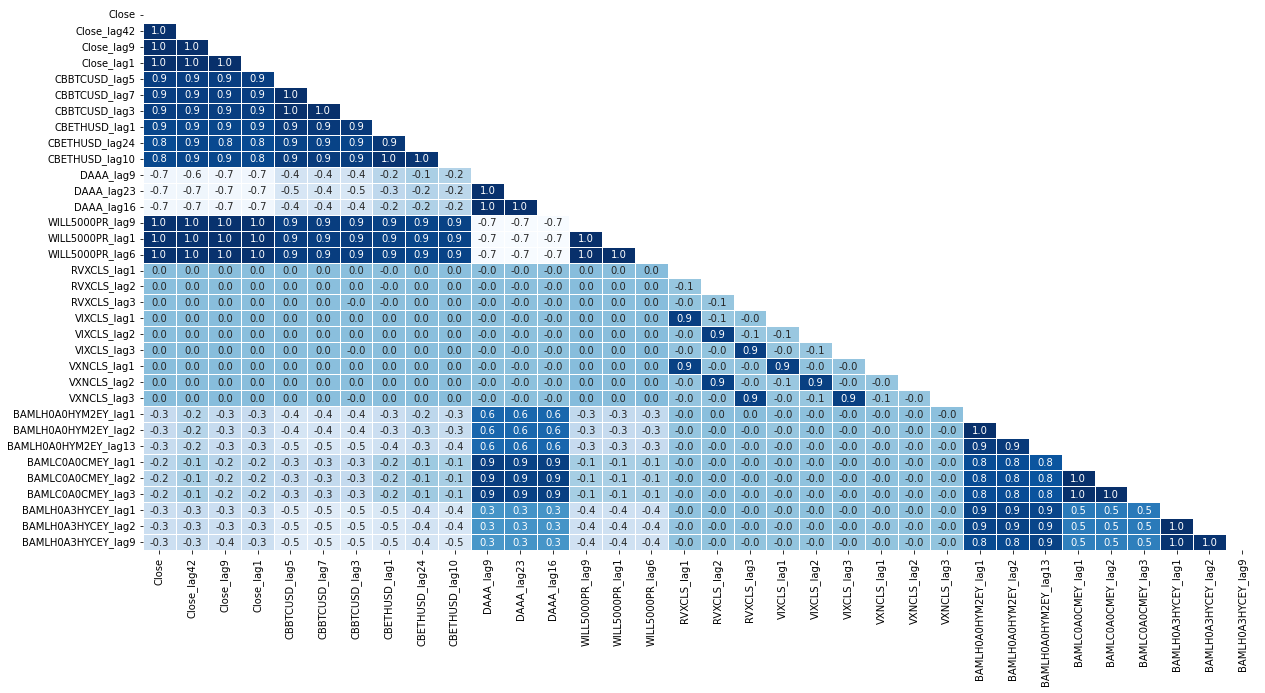

In [98]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_shifted_raw, dtype=bool))
plt.figure(figsize=(20,10))
sns.heatmap(matrix_shifted_raw, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [100]:
predictors_df_shifted_raw = pps.predictors(df_shifted.drop(columns=['Date']), y='Close')
predictors_df_shifted_raw

x      y   ppscore        case  is_valid_score  \
0             Close_lag1  Close  0.973322  regression            True   
1             Close_lag9  Close  0.930079  regression            True   
2            Close_lag42  Close  0.864533  regression            True   
3             WILL5000PR  Close  0.848286  regression            True   
4        WILL5000PR_lag1  Close  0.847292  regression            True   
5        WILL5000PR_lag6  Close  0.824571  regression            True   
6        WILL5000PR_lag9  Close  0.819617  regression            True   
7               CBBTCUSD  Close  0.753433  regression            True   
8          CBBTCUSD_lag3  Close  0.743343  regression            True   
9          CBBTCUSD_lag5  Close  0.738934  regression            True   
10         CBBTCUSD_lag7  Close  0.733157  regression            True   
11              CBETHUSD  Close  0.644623  regression            True   
12         CBETHUSD_lag1  Close  0.640345  regression            True   
13        CBETHUSD_lag10  Close  0.610591  regression            True   
14        CBETHUSD_lag24  Close  0.569914  regression            True   
15            DAAA_lag23  Close  0.502060  regression            True   
16            DAAA_lag16  Close  0.500691  regression            True   
17     BAMLC0A0CMEY_lag3  Close  0.500194  regression            True   
18             DAAA_lag9  Close  0.497362  regression            True   
19     BAMLC0A0CMEY_lag2  Close  0.494324  regression            True   
20                  DAAA  Close  0.486888  regression            True   
21          BAMLC0A0CMEY  Close  0.485765  regression            True   
22     BAMLC0A0CMEY_lag1  Close  0.485185  regression            True   
23  BAMLH0A0HYM2EY_lag13  Close  0.401402  regression            True   
24        BAMLH0A0HYM2EY  Close  0.390811  regression            True   
25   BAMLH0A0HYM2EY_lag2  Close  0.389404  regression            True   
26   BAMLH0A0HYM2EY_lag1  Close  0.387474  regression            True   
27    BAMLH0A3HYCEY_lag2  Close  0.357450  regression            True   
28         BAMLH0A3HYCEY  Close  0.349881  regression            True   
29    BAMLH0A3HYCEY_lag9  Close  0.344416  regression            True   
30    BAMLH0A3HYCEY_lag1  Close  0.336496  regression            True   
31                RVXCLS  Close  0.000000  regression            True   
32                VIXCLS  Close  0.000000  regression            True   
33                VXNCLS  Close  0.000000  regression            True   
34           RVXCLS_lag1  Close  0.000000  regression            True   
35           RVXCLS_lag2  Close  0.000000  regression            True   
36           RVXCLS_lag3  Close  0.000000  regression            True   
37           VIXCLS_lag1  Close  0.000000  regression            True   
38           VIXCLS_lag2  Close  0.000000  regression            True   
39           VIXCLS_lag3  Close  0.000000  regression            True   
40           VXNCLS_lag1  Close  0.000000  regression            True   
41           VXNCLS_lag2  Close  0.000000  regression            True   
42           VXNCLS_lag3  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error     2483.136770    66.244787  DecisionTreeRegressor()  
1   mean absolute error     2484.776331   173.738222  DecisionTreeRegressor()  
2   mean absolute error     2482.896805   336.349391  DecisionTreeRegressor()  
3   mean absolute error     2482.426700   376.618959  DecisionTreeRegressor()  
4   mean absolute error     2483.136770   379.195621  DecisionTreeRegressor()  
5   mean absolute error     2480.773728   435.200095  DecisionTreeRegressor()  
6   mean absolute error     2484.776331   448.210172  DecisionTreeRegressor()  
7   mean absolute error     2988.785160   736.936095  DecisionTreeRegressor()  
8   mean absolute error     2988.765644   767.088729  DecisionTreeRegressor()  
9   mean a

#### Conclusion
On constate trois phénomènes 
<li> Pour Close lags, Will 5000, BTC & ETH  -> résultats attendus. <br>Ils étaient d'ailleurs les plus hauts pps en valeur brute.</li><br>
<li> Pour DAAA, BAMLC0A0CMEY, et BAMLH0A0HYM2EY, les Lags > valeurs du jour.<br>Rappel, il s'agissait ici des conversions base100/Close_raw. Ca marche ?</li><br>
<li>Les valeurs de VIX ne fonctionnent toujours pas en données brutes.<br>Il est nécessaire de faire la mesure sur un Close normalisé et non brut.<br>Le résultat est nul en corrélation & pps</li>

[Text(0, 0, '0.973322'),
 Text(0, 0, '0.930079'),
 Text(0, 0, '0.864533'),
 Text(0, 0, '0.848286'),
 Text(0, 0, '0.847292'),
 Text(0, 0, '0.824571'),
 Text(0, 0, '0.819617'),
 Text(0, 0, '0.753433'),
 Text(0, 0, '0.743343'),
 Text(0, 0, '0.738934'),
 Text(0, 0, '0.733157'),
 Text(0, 0, '0.644623'),
 Text(0, 0, '0.640345'),
 Text(0, 0, '0.610591'),
 Text(0, 0, '0.569914'),
 Text(0, 0, '0.50206'),
 Text(0, 0, '0.500691'),
 Text(0, 0, '0.500194'),
 Text(0, 0, '0.497362'),
 Text(0, 0, '0.494324'),
 Text(0, 0, '0.486888'),
 Text(0, 0, '0.485765'),
 Text(0, 0, '0.485185'),
 Text(0, 0, '0.401402'),
 Text(0, 0, '0.390811'),
 Text(0, 0, '0.389404'),
 Text(0, 0, '0.387474'),
 Text(0, 0, '0.35745'),
 Text(0, 0, '0.349881'),
 Text(0, 0, '0.344416'),
 Text(0, 0, '0.336496'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

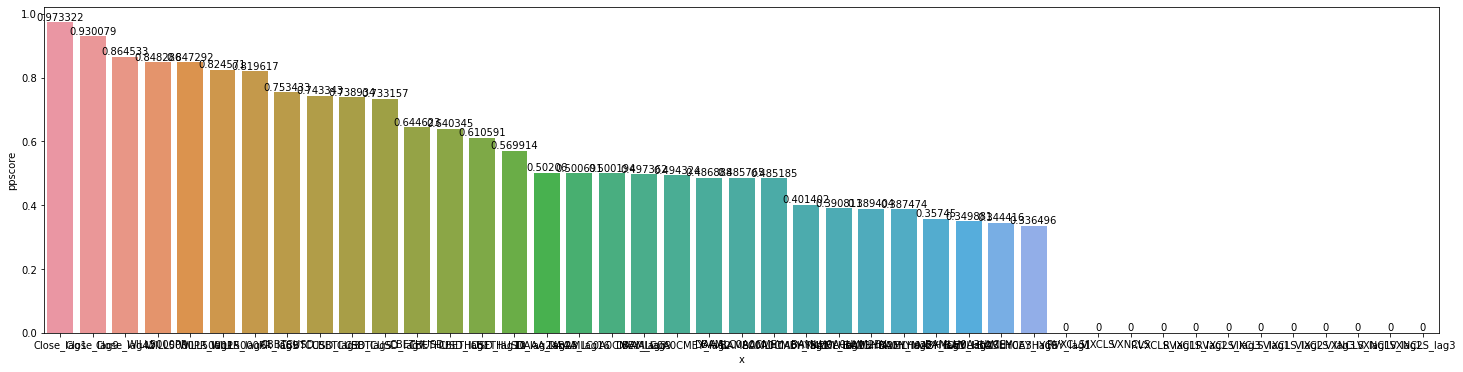

In [102]:
plt.figure(figsize=(25,6))
ax = sns.barplot(data=predictors_df_shifted_raw, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

### Lags on % var (VIX)

In [104]:
d_lags

{'Close': [42, 9, 1],
 'CBBTCUSD': [5, 7, 3],
 'CBETHUSD': [1, 24, 10],
 'DAAA': [9, 23, 16],
 'WILL5000PR': [9, 1, 6],
 'RVXCLS': [1, 2, 3],
 'VIXCLS': [1, 2, 3],
 'VXNCLS': [1, 2, 3],
 'BAMLH0A0HYM2EY': [1, 2, 13],
 'BAMLC0A0CMEY': [1, 2, 3],
 'BAMLH0A3HYCEY': [1, 2, 9]}

In [106]:
df_norm_shifted = df_norm[["Close","RVXCLS","VIXCLS","VXNCLS"]]
cols_norms = df_norm_shifted.columns.to_list()

In [108]:
for colonne in cols_norms[1:]:
  for i in range (1,4):
    df_norm_shifted[colonne+"_lag"+str(i)] = df_shifted[k].shift(i)

In [109]:
df_norm_shifted.columns

Index(['Close', 'RVXCLS', 'VIXCLS', 'VXNCLS', 'RVXCLS_lag1', 'RVXCLS_lag2',
       'RVXCLS_lag3', 'VIXCLS_lag1', 'VIXCLS_lag2', 'VIXCLS_lag3',
       'VXNCLS_lag1', 'VXNCLS_lag2', 'VXNCLS_lag3'],
      dtype='object')

In [110]:
matrix_shifted1000_raw = df_norm_shifted.corr()

<AxesSubplot:>

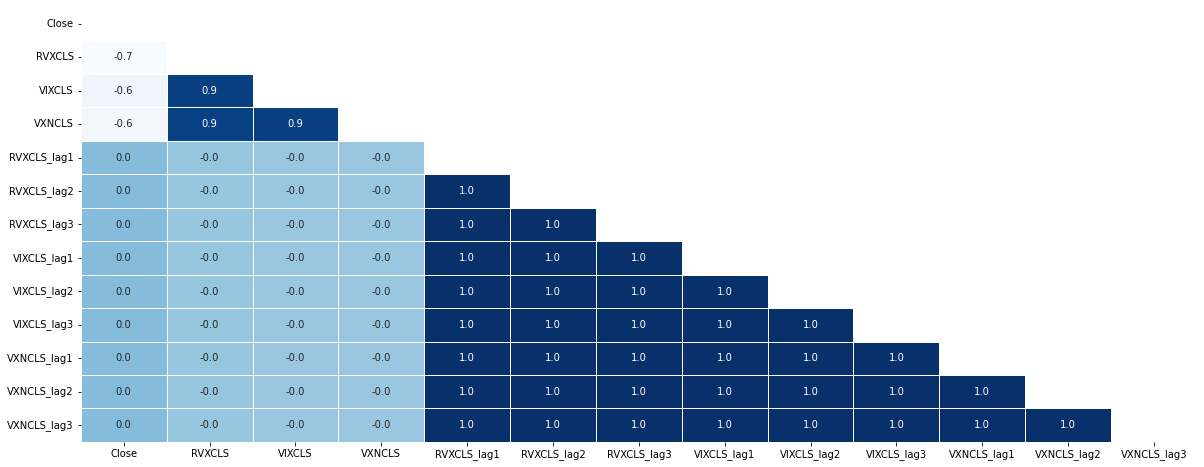

In [111]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix_shifted1000_raw, dtype=bool))
plt.figure(figsize=(20,8))
sns.heatmap(matrix_shifted1000_raw, annot=True, fmt=".1f", cmap='Blues', mask=mask, linewidths=0.5, linecolor='white', cbar=False)

In [112]:
predictors_df_shifted1000_raw = pps.predictors(df_norm_shifted, y='Close')
predictors_df_shifted1000_raw

x      y   ppscore        case  is_valid_score  \
0        RVXCLS  Close  0.067960  regression            True   
1        VXNCLS  Close  0.017968  regression            True   
2        VIXCLS  Close  0.000000  regression            True   
3   RVXCLS_lag1  Close  0.000000  regression            True   
4   RVXCLS_lag2  Close  0.000000  regression            True   
5   RVXCLS_lag3  Close  0.000000  regression            True   
6   VIXCLS_lag1  Close  0.000000  regression            True   
7   VIXCLS_lag2  Close  0.000000  regression            True   
8   VIXCLS_lag3  Close  0.000000  regression            True   
9   VXNCLS_lag1  Close  0.000000  regression            True   
10  VXNCLS_lag2  Close  0.000000  regression            True   
11  VXNCLS_lag3  Close  0.000000  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error        0.919890     0.857375  DecisionTreeRegressor()  
1   mean absolute error        1.053732     1.034799  DecisionTreeRegressor()  
2   mean absolute error        1.174638     1.210314  DecisionTreeRegressor()  
3   mean absolute error        0.970538     1.337844  DecisionTreeRegressor()  
4   mean absolute error        0.970533     1.351277  DecisionTreeRegressor()  
5   mean absolute error        0.970913     1.301081  DecisionTreeRegressor()  
6   mean absolute error        0.970538     1.337844  DecisionTreeRegressor()  
7   mean absolute error        0.970533     1.351277  DecisionTreeRegressor()  
8   mean absolute error        0.970913     1.301081  DecisionTreeRegressor()  
9   mean absolute error        0.970538     1.337844  DecisionTreeRegressor()  
10  mean absolute error        0.970533     1.351277  DecisionTreeRegressor()  
11  mean absolute error        0.970913     1.301081  DecisionTreeRegressor()

[Text(0, 0, '0.0679595'),
 Text(0, 0, '0.0179677'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

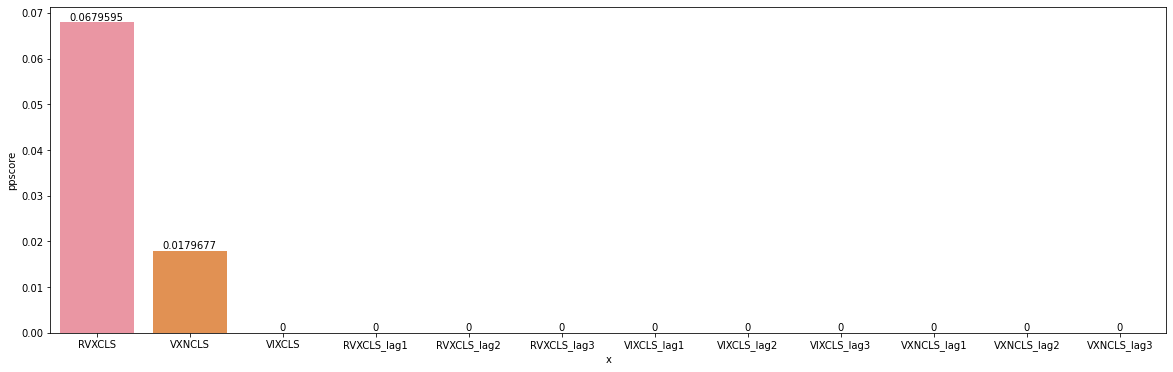

In [113]:
plt.figure(figsize=(20,6))
ax = sns.barplot(data=predictors_df_shifted1000_raw, x="x", y="ppscore")
ax.bar_label(ax.containers[0])

Les lags semblent ne rien apporter.<br>
La seule chose que l'on conserve sur le VIX semble être une corrélation moyenne sur les données du jour. Mais nulles dès le lendemain et à 3j.<br>Donc peu utilisables ?

# Comparaison des pps & correlation en cible catégorielle
Plutôt que de tenter de prédire la valeur de la cloture avec la MAE, on va tenter de prédire l'appartenance à une fourchette de valeurs qui nous intéresse

In [114]:
df_agg.head(1)

Date    Close  AAA10Y  BAMLH0A0HYM2EY  BAMLC0A0CMEY  BAMLC0A0CM  \
0 1997-10-07  1140.74    0.95            8.67          6.56        0.54   

   BAMLH0A0HYM2  BAMLH0A3HYCEY  CBBTCUSD  CBETHUSD  DAAA  DEXUSEU  GVZCLS  \
0          2.62          11.76       NaN       NaN  6.89      NaN     NaN   

   RVXCLS  T10Y2Y  T10YFF  VIXCLS  VXDCLS  VXNCLS  WILL5000PR  
0     NaN    0.27    0.52   20.29   21.48     NaN     9486.69

On va faire les catégories suivantes à +3j, +5j et +10j
<li> [inf ; -5%[ strong sell</li>
<li> [-5% ; -2%[ sell </li>
<li> [-2% ; 2%[ range (incluant frais transaction) </li>
<li> [2% ; 5%[ buy </li>
<li> [2% ; inf[ strong buy</li>


In [115]:
df_categories = df_agg.copy()

In [122]:
df_categories["vClose_3d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(3))*100, 2)
df_categories["vClose_5d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(5))*100, 2)
df_categories["vClose_8d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(8))*100, 2)
df_categories["vClose_13d"] = round(np.log(df_categories.Close / df_categories["Close"].shift(13))*100, 2)

array([[<AxesSubplot:title={'center':'vClose_3d'}>,
        <AxesSubplot:title={'center':'vClose_5d'}>],
       [<AxesSubplot:title={'center':'vClose_8d'}>,
        <AxesSubplot:title={'center':'vClose_13d'}>]], dtype=object)

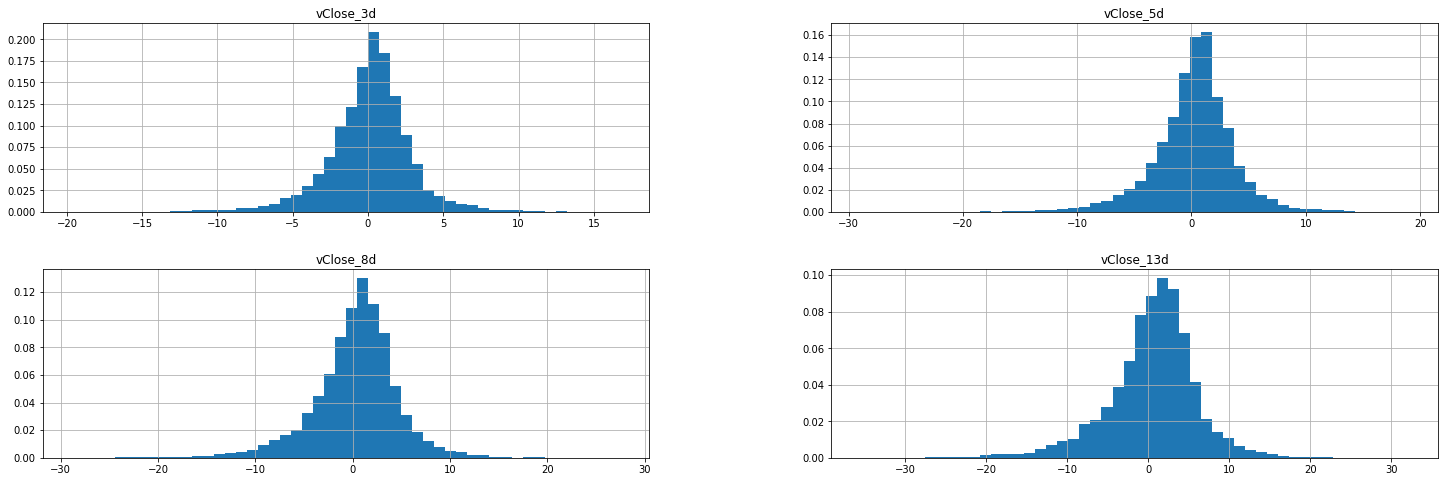

In [123]:
df_categories[["vClose_3d","vClose_5d","vClose_8d","vClose_13d"]].hist(figsize=(25,8),bins=50, density=True)

In [124]:
df_categories[["vClose_3d","vClose_5d","vClose_8d","vClose_13d"]].describe()

vClose_3d    vClose_5d    vClose_8d   vClose_13d
count  6620.000000  6618.000000  6615.000000  6610.000000
mean      0.106881     0.178812     0.288711     0.473306
std       2.845164     3.579264     4.410365     5.526873
min     -19.770000   -29.100000   -28.990000   -35.680000
25%      -1.270000    -1.510000    -1.780000    -2.100000
50%       0.300000     0.460000     0.720000     1.040000
75%       1.600000     2.070000     2.810000     3.650000
max      16.860000    19.140000    27.660000    32.360000

In [125]:
#bins = pd.IntervalIndex.from_tuples([(-30, -5), (-5, -2), (-2, 2), (2, 5), (5, 30)])
bins = [-30, -5, -2, 2, 5, 30]
labels = ["strong sell","sell","range","buy","strong buy"]

In [126]:
df_categories["catClose_3d"] = pd.cut(df_categories["vClose_3d"].to_numpy(), bins, labels=labels)
df_categories["catClose_5d"] = pd.cut(df_categories["vClose_5d"].to_numpy(), bins, labels=labels)
df_categories["catClose_8d"] = pd.cut(df_categories["vClose_8d"].to_numpy(), bins, labels=labels)
df_categories["catClose_13d"] = pd.cut(df_categories["vClose_13d"].to_numpy(), bins, labels=labels)

In [127]:
df_categories["catClose_3d"].value_counts().sort_index()

strong sell     285
sell            856
range          4194
buy            1052
strong buy      233
Name: catClose_3d, dtype: int64

In [128]:
df_categories["catClose_13d"].value_counts().sort_index()

strong sell     865
sell            821
range          2251
buy            1664
strong buy     1007
Name: catClose_13d, dtype: int64

In [147]:
df_categories["vClose_3d"] = round((df_categories.Close - df_categories["Close"].shift(3))/df_categories["Close"].shift(3)*100, 2)
df_categories["vClose_5d"] = round((df_categories.Close - df_categories["Close"].shift(5))/df_categories["Close"].shift(5)*100, 2)
df_categories["vClose_8d"] = round((df_categories.Close - df_categories["Close"].shift(8))/df_categories["Close"].shift(8)*100, 2)
df_categories["vClose_13d"] = round((df_categories.Close - df_categories["Close"].shift(13))/df_categories["Close"].shift(13)*100, 2)

array([[<AxesSubplot:title={'center':'vClose_3d'}>,
        <AxesSubplot:title={'center':'vClose_5d'}>],
       [<AxesSubplot:title={'center':'vClose_8d'}>,
        <AxesSubplot:title={'center':'vClose_13d'}>]], dtype=object)

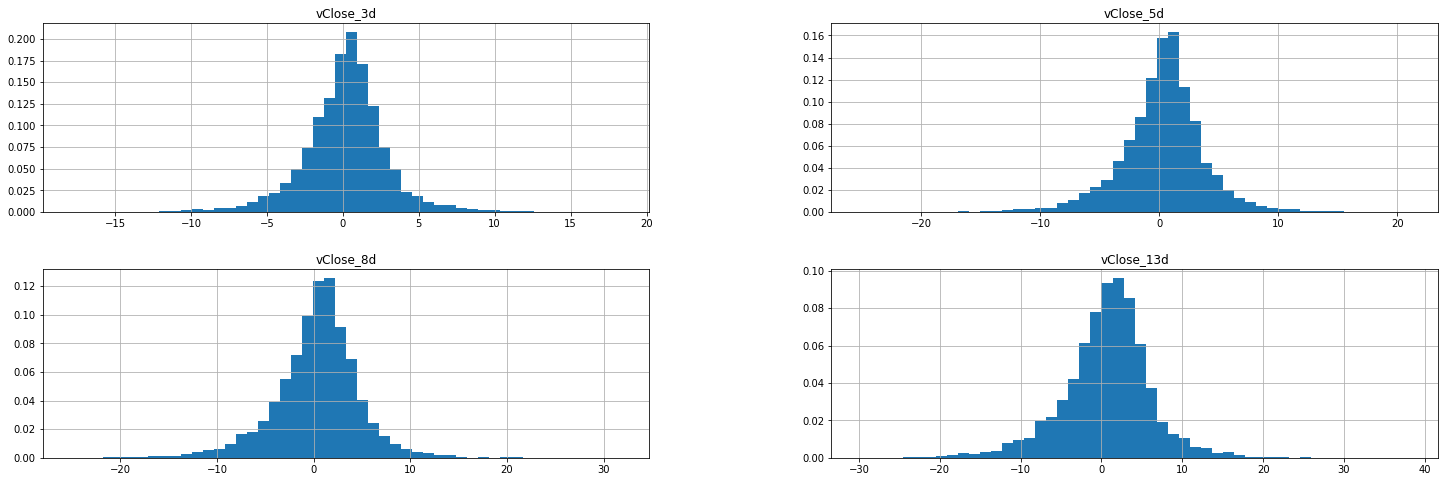

In [148]:
df_categories[["vClose_3d","vClose_5d","vClose_8d","vClose_13d"]].hist(figsize=(25,8),bins=50, density=True)

In [149]:
df_categories["catClose_3d"] = pd.cut(df_categories["vClose_3d"].to_numpy(), bins, labels=labels)
df_categories["catClose_5d"] = pd.cut(df_categories["vClose_5d"].to_numpy(), bins, labels=labels)
df_categories["catClose_8d"] = pd.cut(df_categories["vClose_8d"].to_numpy(), bins, labels=labels)
df_categories["catClose_13d"] = pd.cut(df_categories["vClose_13d"].to_numpy(), bins, labels=labels)

In [150]:
df_categories["catClose_3d"].value_counts().sort_index()

strong sell     268
sell            863
range          4185
buy            1053
strong buy      251
Name: catClose_3d, dtype: int64

In [151]:
df_categories["catClose_13d"].value_counts().sort_index()

strong sell     841
sell            837
range          2248
buy            1631
strong buy     1050
Name: catClose_13d, dtype: int64

Le changement de catégories est relativement similaire entre Ln et %<br>
Mais les distributions sont différentes avec des extrêmes pour Ln.<br>
Peut-être mieux pour prédiction ?<br>
Aussi à +13j, la répartition est plus homogène entre les catégories

Rappel : df_agg données brutes<br>
df_shifted = reconstitution avec raw, base1000 et %

In [152]:
df_categories.columns

Index(['Date', 'Close', 'AAA10Y', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY',
       'BAMLC0A0CM', 'BAMLH0A0HYM2', 'BAMLH0A3HYCEY', 'CBBTCUSD', 'CBETHUSD',
       'DAAA', 'DEXUSEU', 'GVZCLS', 'RVXCLS', 'T10Y2Y', 'T10YFF', 'VIXCLS',
       'VXDCLS', 'VXNCLS', 'WILL5000PR', 'vClose_3d', 'vClose_5d', 'vClose_8d',
       'vClose_13d', 'catClose_3d', 'catClose_5d', 'catClose_8d',
       'catClose_13d'],
      dtype='object')

In [153]:
df_shifted.columns

Index(['Date', 'Close', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'WILL5000PR', 'RVXCLS',
       'VIXCLS', 'VXNCLS', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY', 'BAMLH0A3HYCEY',
       'Close_lag42', 'Close_lag9', 'Close_lag1', 'CBBTCUSD_lag5',
       'CBBTCUSD_lag7', 'CBBTCUSD_lag3', 'CBETHUSD_lag1', 'CBETHUSD_lag24',
       'CBETHUSD_lag10', 'DAAA_lag9', 'DAAA_lag23', 'DAAA_lag16',
       'WILL5000PR_lag9', 'WILL5000PR_lag1', 'WILL5000PR_lag6', 'RVXCLS_lag1',
       'RVXCLS_lag2', 'RVXCLS_lag3', 'VIXCLS_lag1', 'VIXCLS_lag2',
       'VIXCLS_lag3', 'VXNCLS_lag1', 'VXNCLS_lag2', 'VXNCLS_lag3',
       'BAMLH0A0HYM2EY_lag1', 'BAMLH0A0HYM2EY_lag2', 'BAMLH0A0HYM2EY_lag13',
       'BAMLC0A0CMEY_lag1', 'BAMLC0A0CMEY_lag2', 'BAMLC0A0CMEY_lag3',
       'BAMLH0A3HYCEY_lag1', 'BAMLH0A3HYCEY_lag2', 'BAMLH0A3HYCEY_lag9'],
      dtype='object')

In [154]:
df_pps_cat = df_categories[['Date','catClose_3d', 'catClose_5d', 'catClose_8d','catClose_13d']]\
            .merge(df_shifted.drop(columns=['Close', 'CBBTCUSD', 'CBETHUSD', 'DAAA', 'WILL5000PR', 'RVXCLS',\
            'VIXCLS', 'VXNCLS', 'BAMLH0A0HYM2EY', 'BAMLC0A0CMEY', 'BAMLH0A3HYCEY']), how='left', on='Date')

In [155]:
df_pps_cat.columns

Index(['Date', 'catClose_3d', 'catClose_5d', 'catClose_8d', 'catClose_13d',
       'Close_lag42', 'Close_lag9', 'Close_lag1', 'CBBTCUSD_lag5',
       'CBBTCUSD_lag7', 'CBBTCUSD_lag3', 'CBETHUSD_lag1', 'CBETHUSD_lag24',
       'CBETHUSD_lag10', 'DAAA_lag9', 'DAAA_lag23', 'DAAA_lag16',
       'WILL5000PR_lag9', 'WILL5000PR_lag1', 'WILL5000PR_lag6', 'RVXCLS_lag1',
       'RVXCLS_lag2', 'RVXCLS_lag3', 'VIXCLS_lag1', 'VIXCLS_lag2',
       'VIXCLS_lag3', 'VXNCLS_lag1', 'VXNCLS_lag2', 'VXNCLS_lag3',
       'BAMLH0A0HYM2EY_lag1', 'BAMLH0A0HYM2EY_lag2', 'BAMLH0A0HYM2EY_lag13',
       'BAMLC0A0CMEY_lag1', 'BAMLC0A0CMEY_lag2', 'BAMLC0A0CMEY_lag3',
       'BAMLH0A3HYCEY_lag1', 'BAMLH0A3HYCEY_lag2', 'BAMLH0A3HYCEY_lag9'],
      dtype='object')

In [158]:
df_pps_cat.dropna(subset=["catClose_13d"], inplace=True)

If the column whose values are to be predicted a.k.a. the target column has categorical values, we use Label Encoding.

In [160]:
df_pps_cat["catClose_3d"].unique()

['sell', 'strong sell', 'buy', 'range', 'strong buy']
Categories (5, object): ['strong sell' < 'sell' < 'range' < 'buy' < 'strong buy']

In [162]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df_pps_cat['target']= label_encoder.fit_transform(df_pps_cat['catClose_3d'])
  
df_pps_cat['target'].unique()

array([2, 4, 0, 1, 3])

In [165]:
df_pps_cat['target'].value_counts().sort_index()

0    1052
1    4178
2     860
3     250
4     267
Name: target, dtype: int64

In [166]:
df_pps_cat['catClose_3d'].value_counts().sort_index()

strong sell     267
sell            860
range          4178
buy            1052
strong buy      250
Name: catClose_3d, dtype: int64

In [174]:
# Colonnes lags ajustées /Ln 3j
predictors_df_shifted_raw = pps.predictors(df_pps_cat.drop(columns=['Date','target','catClose_5d', 'catClose_8d', 'catClose_3d']), y='catClose_13d')
predictors_df_shifted_raw

x             y   ppscore            case  \
0      BAMLC0A0CMEY_lag1  catClose_13d  0.148796  classification   
1      BAMLC0A0CMEY_lag2  catClose_13d  0.136402  classification   
2   BAMLH0A0HYM2EY_lag13  catClose_13d  0.128126  classification   
3      BAMLC0A0CMEY_lag3  catClose_13d  0.126889  classification   
4         CBETHUSD_lag24  catClose_13d  0.119506  classification   
5     BAMLH0A3HYCEY_lag2  catClose_13d  0.117145  classification   
6          CBBTCUSD_lag5  catClose_13d  0.114418  classification   
7          CBETHUSD_lag1  catClose_13d  0.101063  classification   
8          CBBTCUSD_lag3  catClose_13d  0.098280  classification   
9              DAAA_lag9  catClose_13d  0.097960  classification   
10         CBBTCUSD_lag7  catClose_13d  0.093055  classification   
11    BAMLH0A3HYCEY_lag1  catClose_13d  0.090408  classification   
12            DAAA_lag16  catClose_13d  0.088212  classification   
13   BAMLH0A0HYM2EY_lag2  catClose_13d  0.078955  classification   
14            DAAA_lag23  catClose_13d  0.071521  classification   
15            Close_lag1  catClose_13d  0.069517  classification   
16    BAMLH0A3HYCEY_lag9  catClose_13d  0.069296  classification   
17   BAMLH0A0HYM2EY_lag1  catClose_13d  0.067953  classification   
18        CBETHUSD_lag10  catClose_13d  0.067760  classification   
19       WILL5000PR_lag1  catClose_13d  0.062541  classification   
20           Close_lag42  catClose_13d  0.060089  classification   
21       WILL5000PR_lag6  catClose_13d  0.057422  classification   
22       WILL5000PR_lag9  catClose_13d  0.045421  classification   
23           VXNCLS_lag1  catClose_13d  0.045418  classification   
24            Close_lag9  catClose_13d  0.042648  classification   
25           VXNCLS_lag2  catClose_13d  0.039414  classification   
26           RVXCLS_lag2  catClose_13d  0.028354  classification   
27           VIXCLS_lag1  catClose_13d  0.027577  classification   
28           RVXCLS_lag3  catClose_13d  0.025680  classification   
29           RVXCLS_lag1  catClose_13d  0.019415  classification   
30           VIXCLS_lag2  catClose_13d  0.016254  classification   
31           VIXCLS_lag3  catClose_13d  0.004471  classification   
32           VXNCLS_lag3  catClose_13d  0.000000  classification   

    is_valid_score       metric  baseline_score  model_score  \
0             True  weighted F1        0.268969     0.377744   
1             True  weighted F1        0.254958     0.356583   
2             True  weighted F1        0.253706     0.349325   
3             True  weighted F1        0.259070     0.353086   
4             True  weighted F1        0.266208     0.353900   
5             True  weighted F1        0.254958     0.342235   
6             True  weighted F1        0.274720     0.357706   
7             True  weighted F1        0.268969     0.342850   
8             True  weighted F1        0.254427     0.327702   
9             True  weighted F1        0.238800     0.313367   
10            True  weighted F1        0.261905     0.330588   
11            True  weighted F1        0.268969     0.335061   
12            True  weighted F1        0.239200     0.306312   
13            True  weighted F1        0.254958     0.313782   
14            True  weighted F1        0.229000     0.284143   
15            True  weighted F1        0.238800     0.291716   
16            True  weighted F1        0.263367     0.314413   
17            True  weighted F1        0.268969     0.318645   
18            True  weighted F1        0.274331     0.323502   
19            True  weighted F1        0.238800     0.286407   
20            True  weighted F1        0.244000     0.289428   
21            True  weighted F1        0.238800     0.282510   
22            True  weighted F1        0.238800     0.273375   
23            True  weighted F1        0.233200     0.268027   
24            True  weighted F1        0.238800     0.271263   
25            True  weighted F1        0.24520

In [170]:
pps.score(df_pps_cat,'VIXCLS_lag1','target')

{'x': 'VIXCLS_lag1',
 'y': 'target',
 'ppscore': 0,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 0.4872,
 'model_score': 0.7365096031746032,
 'model': DecisionTreeRegressor()}

In [171]:
pps.score(df_pps_cat,'VIXCLS_lag1','catClose_3d')

{'x': 'VIXCLS_lag1',
 'y': 'catClose_3d',
 'ppscore': 0,
 'case': 'classification',
 'is_valid_score': True,
 'metric': 'weighted F1',
 'baseline_score': 0.4874928361138371,
 'model_score': 0.48008802813500157,
 'model': DecisionTreeClassifier()}